In [214]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import pandas as pd
import numpy as np
import sklearn
import re
import math
import joblib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [215]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from transformers import BertTokenizer, BertForMaskedLM

from sklearn.metrics import (
    recall_score,
    precision_score
  )

from sklearn.metrics import multilabel_confusion_matrix

In [216]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

In [217]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [218]:
time_now = pd.Timestamp.now().strftime("%m-%d-%H-%M")
print(f"Time now: {time_now}")

Time now: 06-02-20-37


# Config

In [219]:
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 'jenfung/CyBERT-Base-MLM-v1.1'
        self.NUM_LABELS_TA = 14
        self.NUM_LABELS_TE = 185

        self.TOKENIZER = BertTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH = 320
        self.BATCH_SIZE = 16

        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.N_VALIDATE_DUR_TRAIN = 3
        self.N_WARMUP = 0
        self.SAVE_BEST_ONLY = True
        self.EPOCHS = 50

In [220]:
TACTIC = ['TA0001', 'TA0002', 'TA0003', 'TA0004', 'TA0005', 'TA0006', 'TA0007', 'TA0008', 'TA0009', 'TA0010', 'TA0011', 'TA0040', 'TA0042', 'TA0043']
TECHNIQUE = ['T1001', 'T1003', 'T1005', 'T1006', 'T1007', 'T1008', 'T1010', 'T1011', 'T1012', 'T1014', 'T1016', 'T1018', 'T1020', 'T1021', 'T1025', 'T1027', 'T1029', 'T1030', 'T1033', 'T1036', 'T1037', 'T1039', 'T1040', 'T1041', 'T1046', 'T1047', 'T1048', 'T1049', 'T1052', 'T1053', 'T1055', 'T1056', 'T1057', 'T1059', 'T1068', 'T1069', 'T1071', 'T1072', 'T1074', 'T1078', 'T1080', 'T1082', 'T1083', 'T1087', 'T1090', 'T1091', 'T1092', 'T1095', 'T1098', 'T1102', 'T1104', 'T1105', 'T1106', 'T1110', 'T1111', 'T1112', 'T1113', 'T1114', 'T1115', 'T1119', 'T1120', 'T1123', 'T1124', 'T1125', 'T1127', 'T1129', 'T1132', 'T1133', 'T1134', 'T1135', 'T1136', 'T1137', 'T1140', 'T1176', 'T1185', 'T1187', 'T1189', 'T1190', 'T1195', 'T1197', 'T1199', 'T1200', 'T1201', 'T1202', 'T1203', 'T1204', 'T1205', 'T1207', 'T1210', 'T1211', 'T1212', 'T1213', 'T1216', 'T1218', 'T1220', 'T1221', 'T1222', 'T1480', 'T1482', 'T1485', 'T1486', 'T1489', 'T1490', 'T1491', 'T1495', 'T1496', 'T1497', 'T1498', 'T1499', 'T1505', 'T1518', 'T1525', 'T1526', 'T1528', 'T1529', 'T1531', 'T1534', 'T1535', 'T1537', 'T1538', 'T1539', 'T1542', 'T1543', 'T1546', 'T1547', 'T1548', 'T1550', 'T1552', 'T1553', 'T1555', 'T1556', 'T1557', 'T1558', 'T1559', 'T1560', 'T1561', 'T1562', 'T1563', 'T1564', 'T1565', 'T1566', 'T1567', 'T1568', 'T1569', 'T1570', 'T1571', 'T1572', 'T1573', 'T1574', 'T1578', 'T1580', 'T1583', 'T1584', 'T1585', 'T1586', 'T1587', 'T1588', 'T1589', 'T1590', 'T1591', 'T1592', 'T1593', 'T1594', 'T1595', 'T1596', 'T1597', 'T1598', 'T1599', 'T1600', 'T1601', 'T1602', 'T1606', 'T1608', 'T1609', 'T1610', 'T1611', 'T1612', 'T1613', 'T1614', 'T1615', 'T1619', 'T1620', 'T1621', 'T1622', 'T1647']
TACTICS_TECHNIQUES_RELATIONSHIP_DF = {
"TA0001":pd.Series(['T1078', 'T1091', 'T1133', 'T1189', 'T1190', 'T1195', 'T1199', 'T1200', 'T1566', 'T1659', 'T1669']),
"TA0002":pd.Series(['T1047', 'T1053', 'T1059', 'T1072', 'T1106', 'T1129', 'T1203', 'T1204', 'T1559', 'T1569', 'T1609', 'T1610', 'T1648', 'T1651', 'T1674', 'T1675']),
"TA0003":pd.Series(['T1037', 'T1053', 'T1078', 'T1098', 'T1112', 'T1133', 'T1136', 'T1137', 'T1176', 'T1197', 'T1205', 'T1505', 'T1525', 'T1542', 'T1543', 'T1546', 'T1547', 'T1554', 'T1556', 'T1574', 'T1653', 'T1668', 'T1671']),
"TA0004":pd.Series(['T1037', 'T1053', 'T1055', 'T1068', 'T1078', 'T1098', 'T1134', 'T1484', 'T1543', 'T1546', 'T1547', 'T1548', 'T1574', 'T1611']),
"TA0005":pd.Series(['T1006', 'T1014', 'T1027', 'T1036', 'T1055', 'T1070', 'T1078', 'T1112', 'T1127', 'T1134', 'T1140', 'T1197', 'T1202', 'T1205', 'T1207', 'T1211', 'T1216', 'T1218', 'T1220', 'T1221', 'T1222', 'T1480', 'T1484', 'T1497', 'T1535', 'T1542', 'T1548', 'T1550', 'T1553', 'T1556', 'T1562', 'T1564', 'T1574', 'T1578', 'T1599', 'T1600', 'T1601', 'T1610', 'T1612', 'T1620', 'T1622', 'T1647', 'T1656', 'T1666', 'T1672']),
"TA0006":pd.Series(['T1003', 'T1040', 'T1056', 'T1110', 'T1111', 'T1187', 'T1212', 'T1528', 'T1539', 'T1552', 'T1555', 'T1556', 'T1557', 'T1558', 'T1606', 'T1621', 'T1649']),
"TA0007":pd.Series(['T1007', 'T1010', 'T1012', 'T1016', 'T1018', 'T1033', 'T1040', 'T1046', 'T1049', 'T1057', 'T1069', 'T1082', 'T1083', 'T1087', 'T1120', 'T1124', 'T1135', 'T1201', 'T1217', 'T1482', 'T1497', 'T1518', 'T1526', 'T1538', 'T1580', 'T1613', 'T1614', 'T1615', 'T1619', 'T1622', 'T1652', 'T1654', 'T1673']),
"TA0008":pd.Series(['T1021', 'T1072', 'T1080', 'T1091', 'T1210', 'T1534', 'T1550', 'T1563', 'T1570']),
"TA0009":pd.Series(['T1005', 'T1025', 'T1039', 'T1056', 'T1074', 'T1113', 'T1114', 'T1115', 'T1119', 'T1123', 'T1125', 'T1185', 'T1213', 'T1530', 'T1557', 'T1560', 'T1602']),
"TA0010":pd.Series(['T1011', 'T1020', 'T1029', 'T1030', 'T1041', 'T1048', 'T1052', 'T1537', 'T1567']),
"TA0011":pd.Series(['T1001', 'T1008', 'T1071', 'T1090', 'T1092', 'T1095', 'T1102', 'T1104', 'T1105', 'T1132', 'T1205', 'T1219', 'T1568', 'T1571', 'T1572', 'T1573', 'T1659', 'T1665']),
"TA0040":pd.Series(['T1485', 'T1486', 'T1489', 'T1490', 'T1491', 'T1495', 'T1496', 'T1498', 'T1499', 'T1529', 'T1531', 'T1561', 'T1565', 'T1657', 'T1667']),                
"TA0042":pd.Series(['T1583', 'T1584', 'T1585', 'T1586', 'T1587', 'T1588', 'T1608', 'T1650']),
"TA0043":pd.Series(['T1589', 'T1590', 'T1591', 'T1592', 'T1593', 'T1594', 'T1595', 'T1596', 'T1597', 'T1598'])
}

In [221]:
df = pd.read_csv('merged_all_columns.csv', encoding='utf-8')
# df_attack['tactic_label'] = df_attack.apply(lambda x: list(x[TACTIC]), axis=1)
# df_attack['technique_label'] = df_attack.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df_tactic_labels = df[TACTIC]
df_technique_labels = df[TECHNIQUE]

In [222]:
print(df_tactic_labels)

      TA0001  TA0002  TA0003  TA0004  TA0005  TA0006  TA0007  TA0008  TA0009  \
0          1       1       0       0       0       0       0       0       0   
1          1       1       0       0       0       0       0       0       0   
2          0       1       0       0       0       1       0       0       0   
3          1       1       0       0       0       0       0       0       0   
4          1       0       0       1       1       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1513       0       1       1       0       0       0       0       0       0   
1514       0       0       0       0       0       0       0       0       0   
1515       0       0       0       1       0       0       0       0       0   
1516       0       1       0       0       0       0       0       0       1   
1517       0       0       0       0       0       0       0       0       0   

      TA0010  TA0011  TA0040  TA0042  T

In [223]:
print(df_technique_labels)

      T1001  T1003  T1005  T1006  T1007  T1008  T1010  T1011  T1012  T1014  \
0         0      0      0      0      0      0      0      0      0      0   
1         0      0      0      0      0      0      0      0      0      0   
2         0      1      0      0      0      0      0      0      0      0   
3         0      0      0      0      0      0      0      0      0      0   
4         0      0      0      0      0      0      0      0      0      0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1513      0      0      0      0      0      0      0      0      0      0   
1514      0      0      0      0      0      0      0      0      0      0   
1515      0      0      0      0      0      0      0      0      0      0   
1516      0      0      1      0      0      0      0      0      0      0   
1517      0      0      0      0      0      0      0      0      0      0   

      ...  T1611  T1612  T1613  T1614  T1615  T1619  T1620  T16

In [224]:
df['tactic_label'] = df.apply(lambda x: list(x[TACTIC]), axis=1)
df['technique_label'] = df.apply(lambda x: list(x[TECHNIQUE]), axis=1)


# Data processing

In [225]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

In [226]:
import nltk

resources = [
    "punkt",
    "stopwords",
    "wordnet",
    "omw-1.4",
    "averaged_perceptron_tagger",
    "averaged_perceptron_tagger_eng"
]

for res in resources:
    try:
        nltk.data.find(res)
        print(f"{res} ✅ 已安裝")
    except LookupError:
        print(f"{res} ⛔ 未安裝，開始下載...")
        nltk.download(res)


punkt ⛔ 未安裝，開始下載...
stopwords ⛔ 未安裝，開始下載...
wordnet ⛔ 未安裝，開始下載...
omw-1.4 ⛔ 未安裝，開始下載...
averaged_perceptron_tagger ⛔ 未安裝，開始下載...
averaged_perceptron_tagger_eng ⛔ 未安裝，開始下載...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_t

In [227]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def ioc_sub(text):
    def reg_handler(obj):
        s = obj.group(1)
        s = ' '.join(s.split('\\'))
        return s

    def file_handler(obj):
        s = obj.group(2)
        s = s.split('\\')[-1]
        return s
    
    text = re.sub(r'(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|\[\.\])){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\/([0-2][0-9]|3[0-2]|[0-9]))?', 'IPv4', text)
    text = re.sub(r'\b(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})\b', 'IP', text)
    text = re.sub(r'\b(CVE\-[0-9]{4}\-[0-9]{4,6})\b', 'CVE', text)
    text = re.sub(r'CVE-[0-9]{4}-[0-9]{4,6}', 'vulnerability', text)
    text = re.sub(r'\b([a-z][_a-z0-9-.]+@[a-z0-9-]+\.[a-z]+)\b', 'email', text)
    text = re.sub(r'\b((HKLM|HKCU|HKCR|HKU|HKCC)\\[\\A-Za-z0-9-_]+)\b', reg_handler, text)
    text = re.sub(r'\b([a-zA-Z]{1}:\\([0-9a-zA-Z_\.\-\/\\]+))\b', file_handler, text)
    text = re.sub(r'\b([a-f0-9]{32}|[A-F0-9]{32})\b', 'MD5', text)
    text = re.sub(r'\b([a-f0-9]{40}|[A-F0-9]{40})\b', 'SHA1', text)
    text = re.sub(r'\b([a-f0-9]{64}|[A-F0-9]{64})\b', 'SHA256', text)
    text = re.sub(r'\d+:[A-Za-z0-9/+]+:[A-Za-z0-9/+]+', 'ssdeep', text)
    text = re.sub(r'\b[a-fA-F\d]{32}\b|\b[a-fA-F\d]{40}\b|\b[a-fA-F\d]{64}\b', 'hash', text)
    text = re.sub(r'h[tx][tx]ps?:[\\\/][\\\/](?:[0-9a-zA-Z_\.\-\/\\]|\[\.\])+', 'URL', text)
    text = re.sub(r'((?:[0-9a-zA-Z_\-]+\.)+(?:(?!exe|dll)[a-z]{2,4}))', 'domain', text)
    text = re.sub(r'[a-fA-F0-9]{16}', '', text)
    text = re.sub(r'[0-9]{8}', '', text)
    text = re.sub(r'x[A-Fa-f0-9]{2}', '', text)
    
    return text

def rmstopword_and_lemmatize(text):
    token = [word for word in word_tokenize(text.lower()) if word not in stopwords.words('english')]
    # tag = pos_tag(token)
    tag = nltk.pos_tag(token, lang='eng')
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(list(map(lambda x: lemmatizer.lemmatize(x[0], pos=get_wordnet_pos(x[1])), tag)))
    
    return text

def preprocess(text):
    text = str(text)
    #text = text.lower()
    text = re.sub(r'etc\.', '', text)
    text = re.sub(r'et al\.', '', text)
    text = re.sub(r'e\.g\.', '', text)
    text = re.sub(r'i\.e\.', '', text)
    #text = re.sub(r'\[.\]', '.', text)
    text = re.sub(r'\[\d+\]', '', text)
    
    text = ioc_sub(text)
    
    text = re.sub(r'[^A-Za-z0-9_\[\]]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    text = rmstopword_and_lemmatize(text)
    
    text = re.sub(r'[\[\]]', ' ', text)
    text = re.sub(r' [a-z0-9] ', '', text)
    
    return text


In [228]:
df['text_clean'] = df['Text'].map(lambda t: preprocess(t))

In [229]:
print(df['text_clean'][0])

waspthemes visual cs style editor aka yellow pencil visual theme customizer plugin2wordpress allows yp_option_update csrf demonstrate use yp_remote_get obtain admin access


In [230]:
print(df.iloc[0])

ID                                                    CVE_2019_11886
Text               The WaspThemes Visual CSS Style Editor (aka ye...
TA0001                                                             1
TA0002                                                             1
TA0003                                                             0
                                         ...                        
T1622                                                              0
T1647                                                              0
tactic_label              [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
technique_label    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
text_clean         waspthemes visual cs style editor aka yellow p...
Name: 0, Length: 204, dtype: object


# Dataset & Dataloader

In [231]:
def get_texts(df):
    texts = df['text']
    texts = texts.values.tolist()
    return texts

def get_labels(df):
    labels = df['labels'].values
    return labels

def get_ids(df):
    ids = df['ID'].values.tolist()

In [232]:
from torch.utils.data import Dataset, DataLoader
class TransformerDataset_ta(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset_ta, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = Config().TOKENIZER
        self.max_length = Config().MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

In [233]:

class TransformerDataset_te(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset_te, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = Config().TOKENIZER
        self.max_length = Config().MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

In [234]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=2222)
validation, test = train_test_split(test, test_size=0.5, random_state=2222)

In [235]:
df_ta_train = train[['text_clean', 'tactic_label']]
df_ta_val = validation[['text_clean', 'tactic_label']]
df_ta_test = test[['text_clean', 'tactic_label']]
df_ta_train = df_ta_train.rename(columns={'text_clean':'text', 'tactic_label':'labels'})
df_ta_val = df_ta_val.rename(columns={'text_clean':'text', 'tactic_label':'labels'})
df_ta_test = df_ta_test.rename(columns={'text_clean':'text', 'tactic_label':'labels'})


In [236]:
# df_te_train = df.iloc[train.index][['text_clean', 'technique_label']]
# df_te_val = df.iloc[validation.index][['text_clean', 'technique_label']]
# df_te_test = df.iloc[test.index][['text_clean', 'technique_label']]
# df_te_train = df_te_train.rename(columns={'text_clean':'text', 'technique_label':'labels'})
# df_te_val = df_te_val.rename(columns={'text_clean':'text', 'technique_label':'labels'})
# df_te_test = df_te_test.rename(columns={'text_clean':'text', 'technique_label':'labels'})

In [237]:
train_data_ta = TransformerDataset_ta(df_ta_train, range(len(df_ta_train)))
val_data_ta = TransformerDataset_ta(df_ta_val, range(len(df_ta_val)))
test_data_ta = TransformerDataset_ta(df_ta_test, range(len(df_ta_test)))

In [238]:
# train_data_te = TransformerDataset_te(df_ta_train, range(len(df_te_train)))
# val_data_te = TransformerDataset_te(df_ta_val, range(len(df_te_val)))
# test_data_te = TransformerDataset_te(df_ta_test, range(len(df_te_test)))

In [239]:
train_dataloader_ta = DataLoader(train_data_ta, batch_size=Config().BATCH_SIZE)
val_dataloader_ta = DataLoader(val_data_ta, batch_size=Config().BATCH_SIZE)
test_dataloader_ta = DataLoader(test_data_ta, batch_size=Config().BATCH_SIZE)

In [240]:
# train_dataloader_te = DataLoader(train_data_te, batch_size=Config().BATCH_SIZE)
# val_dataloader_te = DataLoader(val_data_te, batch_size=Config().BATCH_SIZE)
# test_dataloader_te = DataLoader(test_data_te, batch_size=Config().BATCH_SIZE)

In [241]:
train_dataloader = train_dataloader_ta
val_dataloader = val_dataloader_ta
test_dataloader = test_dataloader_ta

In [242]:
b = next(iter(train_dataloader_ta))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

input_ids shape: torch.Size([16, 320])
attention_mask shape: torch.Size([16, 320])
labels shape: torch.Size([16, 14])


# Model

In [243]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.transformer_model = AutoModel.from_pretrained(
                Config().MODEL_PATH
        )
        self.dropout = nn.Dropout(0.3)

        self.output = nn.Linear(768, Config().NUM_LABELS_TA)

    def forward(
        self,
        input_ids,
        attention_mask=None,
        token_type_ids=None
        ):

        _, o2 = self.transformer_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )

        x = self.dropout(o2)
        out = self.output(x)

        return out

# Train and test

In [244]:
BEST_F1 = 0
BEST_TRUE = []
BEST_PREDICTED = []

In [245]:
metrics_log = [] 

In [246]:
def val(model, val_dataloader, criterion, is_final_test=False):
    global BEST_F1, BEST_TRUE, BEST_PREDICTED, device

    val_loss = 0
    true, pred = [], []

    model.eval()

    results = {}

    for step, batch in enumerate(val_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

    # avg_val_loss = val_loss / len(val_dataloader)
    # print('Val loss:', avg_val_loss)
    # print('Val accuracy:', accuracy_score(true, pred))

    # print('Val precision:', precision_score(true, pred, average='weighted'))
    # print('Val recall:', recall_score(true, pred, average='weighted'))

    # val_micro_f1_score = f1_score(true, pred, average='micro')
    # print('Val micro f1 score:', val_micro_f1_score)

    # val_macro_f1_score = f1_score(true, pred, average='macro')
    # print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true, pred, average='weighted')
    # print('Val weighted f1 score:', val_weighted_f1_score)

    results.update({
        "f1_sampled": f1_score(true, pred, average='samples', zero_division=0),
        "f1_micro": f1_score(true, pred, average='micro', zero_division=0),
        "f1_macro": f1_score(true, pred, average='macro', zero_division=0),
        "f_05_sample": fbeta_score(true, pred, average='samples', beta=0.5, zero_division=0),
        "f_05_micro": fbeta_score(true, pred, average='micro', beta=0.5, zero_division=0),
        "f_05_macro": fbeta_score(true, pred, average='macro', beta=0.5, zero_division=0),
        "precision_sampled": precision_score(true, pred, average='samples', zero_division=0),
        "precision_micro": precision_score(true, pred, average='micro', zero_division=0),
        "precision_macro": precision_score(true, pred, average='macro', zero_division=0),
        "recall_sampled": recall_score(true, pred, average='samples', zero_division=0),
        "recall_micro": recall_score(true, pred, average='micro', zero_division=0),
        "recall_macro": recall_score(true, pred, average='macro', zero_division=0),
        "accuracy": accuracy_score(true, pred),
        })

    labels_float = labels.astype(float)
    results.update({
        "coverage_error": coverage_error(labels_float, logits),
        "label_ranking_loss": label_ranking_loss(labels_float, logits),
        "lrap": label_ranking_average_precision_score(labels_float, logits),
    })

    metrics_log.append(results.copy())

    print(results)


    if (is_final_test is True):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true
      BEST_PREDICTED = pred
    elif (val_weighted_f1_score > BEST_F1):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true
      BEST_PREDICTED = pred

    return val_weighted_f1_score



In [247]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch):
    global device
    nv = Config().N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]

    train_loss = 0
    train_losses = []

    for step, batch in enumerate(tqdm(train_dataloader,
                                      desc='Epoch ' + str(epoch))):
        model.train()

        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

        loss = criterion(logits, b_labels)
        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)


    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

In [248]:
def run():
    global train_data, val_data, test_data, train_dataloader, val_dataloader, test_dataloader, model
    torch.manual_seed(Config().SEED)

    criterion = nn.BCEWithLogitsLoss()

    if Config().FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=Config().LR)

    num_training_steps = len(train_dataloader) * Config().EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_weighted_f1_score = float('-inf')
    for epoch in range(Config().EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_weighted_f1_score = val(model, val_dataloader, criterion)

        if Config().SAVE_BEST_ONLY:
            if val_weighted_f1_score > max_val_weighted_f1_score:
                best_model = copy.deepcopy(model)

                model_name = 'cybert_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val: {max_val_weighted_f1_score} -> {val_weighted_f1_score}')
                max_val_weighted_f1_score = val_weighted_f1_score

    return best_model, max_val_weighted_f1_score

# Tactic_multi model

In [249]:
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import accuracy_score

In [250]:
project_dir = './'
config = Config()
device = Config().DEVICE
model = Model()
model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at jenfung/CyBERT-Base-MLM-v1.1 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model(
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31820, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [251]:
best_model_ta, best_val_weighted_f1_score_ta = run()

Epoch 0:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 0:   1%|▏         | 1/76 [00:02<03:16,  2.63s/it]

{'f1_sampled': 0.1728331244778613, 'f1_micro': 0.1861152141802068, 'f1_macro': 0.06776794550438707, 'f_05_sample': 0.15579375548364877, 'f_05_micro': 0.15941295546558704, 'f_05_macro': 0.05640453282830502, 'precision_sampled': 0.14934210526315786, 'precision_micro': 0.14549653579676675, 'precision_macro': 0.05210065179900627, 'recall_sampled': 0.2507675438596491, 'recall_micro': 0.2581967213114754, 'recall_macro': 0.20325652537612596, 'accuracy': 0.0, 'coverage_error': np.float64(12.625), 'label_ranking_loss': np.float64(0.8094769813519813), 'lrap': np.float64(0.2120535714285714)}


Epoch 0: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.3498854786157608
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}
--- Best Model. Val: -inf -> 0.0


Epoch 1:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 1:   1%|▏         | 1/76 [00:02<03:17,  2.64s/it]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}


Epoch 1: 100%|██████████| 76/76 [00:22<00:00,  3.30it/s]


Training loss: 0.28881627105568586
{'f1_sampled': 0.15109649122807015, 'f1_micro': 0.20069204152249134, 'f1_macro': 0.04227405247813411, 'f_05_sample': 0.1697211779448622, 'f_05_micro': 0.3419811320754717, 'f_05_macro': 0.04445125689760883, 'precision_sampled': 0.19078947368421054, 'precision_micro': 0.6444444444444445, 'precision_macro': 0.046031746031746035, 'recall_sampled': 0.1337719298245614, 'recall_micro': 0.11885245901639344, 'recall_macro': 0.03908355795148248, 'accuracy': 0.13157894736842105, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}
--- Best Model. Val: 0.0 -> 0.1285547005687521


Epoch 2:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 2:   1%|▏         | 1/76 [00:02<03:16,  2.62s/it]

{'f1_sampled': 0.15548245614035086, 'f1_micro': 0.20689655172413793, 'f1_macro': 0.04329004329004329, 'f_05_sample': 0.17520363408521306, 'f_05_micro': 0.35046728971962615, 'f_05_macro': 0.045207956600361664, 'precision_sampled': 0.19736842105263158, 'precision_micro': 0.6521739130434783, 'precision_macro': 0.046583850931677016, 'recall_sampled': 0.1370614035087719, 'recall_micro': 0.12295081967213115, 'recall_macro': 0.04043126684636118, 'accuracy': 0.13157894736842105, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}


Epoch 2: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.2671453356742859
{'f1_sampled': 0.2928884711779448, 'f1_micro': 0.3696969696969697, 'f1_macro': 0.11916004965685241, 'f_05_sample': 0.31426221804511273, 'f_05_micro': 0.5187074829931972, 'f_05_macro': 0.1443519993705867, 'precision_sampled': 0.34210526315789475, 'precision_micro': 0.7093023255813954, 'precision_macro': 0.1978684083947242, 'recall_sampled': 0.2823464912280702, 'recall_micro': 0.25, 'recall_macro': 0.10008962054879375, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.7067307692307692), 'lrap': np.float64(0.3214285714285714)}
--- Best Model. Val: 0.1285547005687521 -> 0.29010318810662317


Epoch 3:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 3:   1%|▏         | 1/76 [00:02<03:19,  2.66s/it]

{'f1_sampled': 0.3140350877192983, 'f1_micro': 0.39644970414201186, 'f1_macro': 0.12418058132343845, 'f_05_sample': 0.3303440893901421, 'f_05_micro': 0.5403225806451613, 'f_05_macro': 0.1421078150100439, 'precision_sampled': 0.3519736842105263, 'precision_micro': 0.7127659574468085, 'precision_macro': 0.16194899012236474, 'recall_sampled': 0.31085526315789475, 'recall_micro': 0.27459016393442626, 'recall_macro': 0.1077929069494902, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.7067307692307692), 'lrap': np.float64(0.3214285714285714)}


Epoch 3: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.24010371985404114
{'f1_sampled': 0.3114035087719298, 'f1_micro': 0.3893805309734513, 'f1_macro': 0.12586027622613297, 'f_05_sample': 0.33134920634920634, 'f_05_micro': 0.5288461538461539, 'f_05_macro': 0.14672274183342562, 'precision_sampled': 0.35526315789473684, 'precision_micro': 0.6947368421052632, 'precision_macro': 0.1845238095238095, 'recall_sampled': 0.3026315789473684, 'recall_micro': 0.27049180327868855, 'recall_macro': 0.10968655304615693, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6442307692307692), 'lrap': np.float64(0.37499999999999994)}
--- Best Model. Val: 0.29010318810662317 -> 0.30575003254459326


Epoch 4:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 4:   1%|▏         | 1/76 [00:02<03:16,  2.63s/it]

{'f1_sampled': 0.32534461152882205, 'f1_micro': 0.4124293785310734, 'f1_macro': 0.13534512045287322, 'f_05_sample': 0.3401211361737678, 'f_05_micro': 0.533625730994152, 'f_05_macro': 0.15673720296189003, 'precision_sampled': 0.3618421052631579, 'precision_micro': 0.6636363636363637, 'precision_macro': 0.1936053077357425, 'recall_sampled': 0.3267543859649123, 'recall_micro': 0.29918032786885246, 'recall_macro': 0.12093908523212402, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6442307692307692), 'lrap': np.float64(0.37499999999999994)}


Epoch 4: 100%|██████████| 76/76 [00:22<00:00,  3.31it/s]


Training loss: 0.2146671914348477
{'f1_sampled': 0.362406015037594, 'f1_micro': 0.4369747899159664, 'f1_macro': 0.19232362637179407, 'f_05_sample': 0.3928832497911446, 'f_05_micro': 0.5603448275862069, 'f_05_macro': 0.23201517043374426, 'precision_sampled': 0.4309210526315789, 'precision_micro': 0.6902654867256637, 'precision_macro': 0.2804924137676751, 'recall_sampled': 0.34210526315789475, 'recall_micro': 0.319672131147541, 'recall_macro': 0.1556408192868012, 'accuracy': 0.25, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.48878205128205127), 'lrap': np.float64(0.5565476190476191)}
--- Best Model. Val: 0.30575003254459326 -> 0.391431649359547


Epoch 5:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 5:   1%|▏         | 1/76 [00:02<03:16,  2.62s/it]

{'f1_sampled': 0.3770989974937344, 'f1_micro': 0.45125348189415043, 'f1_macro': 0.1871315192743764, 'f_05_sample': 0.40983970342522974, 'f_05_micro': 0.5752840909090909, 'f_05_macro': 0.22637287482170307, 'precision_sampled': 0.4506578947368421, 'precision_micro': 0.7043478260869566, 'precision_macro': 0.2782830523513753, 'recall_sampled': 0.35471491228070173, 'recall_micro': 0.3319672131147541, 'recall_macro': 0.15350677147467853, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.530448717948718), 'lrap': np.float64(0.5238095238095238)}


Epoch 5: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.1931615213030263
{'f1_sampled': 0.39266917293233083, 'f1_micro': 0.4671916010498688, 'f1_macro': 0.19651811879031264, 'f_05_sample': 0.42856348695164487, 'f_05_micro': 0.5618686868686869, 'f_05_macro': 0.2196928539391829, 'precision_sampled': 0.4758771929824562, 'precision_micro': 0.6496350364963503, 'precision_macro': 0.25975690975690974, 'recall_sampled': 0.37225877192982454, 'recall_micro': 0.36475409836065575, 'recall_macro': 0.1834161535584409, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.4471153846153846), 'lrap': np.float64(0.5892857142857143)}
--- Best Model. Val: 0.391431649359547 -> 0.3989699522590509


Epoch 6:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 6:   1%|▏         | 1/76 [00:02<03:19,  2.66s/it]

{'f1_sampled': 0.3922305764411027, 'f1_micro': 0.46194225721784776, 'f1_macro': 0.2012149921924358, 'f_05_sample': 0.42742783532257217, 'f_05_micro': 0.5555555555555556, 'f_05_macro': 0.22734242294576057, 'precision_sampled': 0.47258771929824567, 'precision_micro': 0.6423357664233577, 'precision_macro': 0.2682651050850962, 'recall_sampled': 0.3717105263157895, 'recall_micro': 0.36065573770491804, 'recall_macro': 0.1833097457817106, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.4471153846153846), 'lrap': np.float64(0.5892857142857143)}


Epoch 6: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.17194222776513352
{'f1_sampled': 0.39771303258145363, 'f1_micro': 0.47493403693931396, 'f1_macro': 0.19686998937506034, 'f_05_sample': 0.4310899261557156, 'f_05_micro': 0.5739795918367347, 'f_05_macro': 0.22381274021734815, 'precision_sampled': 0.47368421052631576, 'precision_micro': 0.6666666666666666, 'precision_macro': 0.26028184581376074, 'recall_sampled': 0.3771929824561403, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.17292627090863502, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5512820512820513), 'lrap': np.float64(0.5029761904761905)}
--- Best Model. Val: 0.3989699522590509 -> 0.4176169099635332


Epoch 7:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 7:   1%|▏         | 1/76 [00:02<03:15,  2.61s/it]

{'f1_sampled': 0.4161340852130325, 'f1_micro': 0.4831168831168831, 'f1_macro': 0.19960807092346647, 'f_05_sample': 0.44894706901285847, 'f_05_micro': 0.5754950495049505, 'f_05_macro': 0.22321824798782178, 'precision_sampled': 0.4912280701754385, 'precision_micro': 0.6595744680851063, 'precision_macro': 0.2572871572871573, 'recall_sampled': 0.39692982456140347, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.18082601099334816, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5512820512820513), 'lrap': np.float64(0.5029761904761905)}


Epoch 7: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.14980659496627355
{'f1_sampled': 0.45275689223057636, 'f1_micro': 0.5196078431372549, 'f1_macro': 0.22684128196733241, 'f_05_sample': 0.48202373284610134, 'f_05_micro': 0.5888888888888889, 'f_05_macro': 0.2502309533321793, 'precision_sampled': 0.5186403508771931, 'precision_micro': 0.6463414634146342, 'precision_macro': 0.283932052353105, 'recall_sampled': 0.437719298245614, 'recall_micro': 0.4344262295081967, 'recall_macro': 0.2059037064704716, 'accuracy': 0.3223684210526316, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5512820512820513), 'lrap': np.float64(0.5029761904761905)}
--- Best Model. Val: 0.4176169099635332 -> 0.46487219627046045


Epoch 8:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 8:   1%|▏         | 1/76 [00:02<03:20,  2.67s/it]

{'f1_sampled': 0.4538533834586467, 'f1_micro': 0.524822695035461, 'f1_macro': 0.23075386724665056, 'f_05_sample': 0.47556820007477896, 'f_05_micro': 0.578125, 'f_05_macro': 0.2477693680420821, 'precision_sampled': 0.5043859649122807, 'precision_micro': 0.6201117318435754, 'precision_macro': 0.2761640578204046, 'recall_sampled': 0.45087719298245615, 'recall_micro': 0.45491803278688525, 'recall_macro': 0.21875893914325087, 'accuracy': 0.3026315789473684, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5096153846153846), 'lrap': np.float64(0.5357142857142857)}


Epoch 8: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.1313895458649648
{'f1_sampled': 0.42929197994987467, 'f1_micro': 0.4879356568364611, 'f1_macro': 0.22398905830989113, 'f_05_sample': 0.46376156737998847, 'f_05_micro': 0.5986842105263158, 'f_05_macro': 0.26207812041577605, 'precision_sampled': 0.5054824561403508, 'precision_micro': 0.7054263565891473, 'precision_macro': 0.29844331564997434, 'recall_sampled': 0.40460526315789475, 'recall_micro': 0.3729508196721312, 'recall_macro': 0.18305971236240434, 'accuracy': 0.3157894736842105, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5512820512820513), 'lrap': np.float64(0.5029761904761905)}


Epoch 9:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 9:   1%|▏         | 1/76 [00:02<03:16,  2.63s/it]

{'f1_sampled': 0.44573934837092727, 'f1_micro': 0.5052631578947369, 'f1_macro': 0.23099298614951325, 'f_05_sample': 0.47832923655292076, 'f_05_micro': 0.6091370558375635, 'f_05_macro': 0.2680262602108855, 'precision_sampled': 0.518640350877193, 'precision_micro': 0.7058823529411765, 'precision_macro': 0.3036052140154308, 'recall_sampled': 0.4232456140350877, 'recall_micro': 0.39344262295081966, 'recall_macro': 0.1914117406224368, 'accuracy': 0.34210526315789475, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5512820512820513), 'lrap': np.float64(0.5029761904761905)}


Epoch 9: 100%|██████████| 76/76 [00:22<00:00,  3.31it/s]


Training loss: 0.11581586820906714
{'f1_sampled': 0.3984335839598997, 'f1_micro': 0.4648648648648649, 'f1_macro': 0.21089380090682083, 'f_05_sample': 0.4308211434033803, 'f_05_micro': 0.5748663101604278, 'f_05_macro': 0.2489844527065481, 'precision_sampled': 0.47039473684210525, 'precision_micro': 0.6825396825396826, 'precision_macro': 0.2843381555787571, 'recall_sampled': 0.37467105263157896, 'recall_micro': 0.3524590163934426, 'recall_macro': 0.16911633970109025, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 10:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 10:   1%|▏         | 1/76 [00:02<03:18,  2.64s/it]

{'f1_sampled': 0.3901002506265664, 'f1_micro': 0.4673913043478261, 'f1_macro': 0.20869710034655212, 'f_05_sample': 0.41851291070041075, 'f_05_micro': 0.581081081081081, 'f_05_macro': 0.24810951879289528, 'precision_sampled': 0.45394736842105265, 'precision_micro': 0.6935483870967742, 'precision_macro': 0.28759012634224856, 'recall_sampled': 0.37138157894736845, 'recall_micro': 0.3524590163934426, 'recall_macro': 0.16729582138881785, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 10: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.10228771794783442
{'f1_sampled': 0.4357456140350877, 'f1_micro': 0.4696969696969697, 'f1_macro': 0.2130642800855567, 'f_05_sample': 0.47145206766917286, 'f_05_micro': 0.545774647887324, 'f_05_macro': 0.24525088992265906, 'precision_sampled': 0.5131578947368421, 'precision_micro': 0.6118421052631579, 'precision_macro': 0.2820938929491561, 'recall_sampled': 0.4111842105263158, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.18357969307446134, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.530448717948718), 'lrap': np.float64(0.5238095238095238)}


Epoch 11:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 11:   1%|▏         | 1/76 [00:02<03:15,  2.61s/it]

{'f1_sampled': 0.44749373433583955, 'f1_micro': 0.48743718592964824, 'f1_macro': 0.22347229642987007, 'f_05_sample': 0.48520841366236106, 'f_05_micro': 0.563953488372093, 'f_05_macro': 0.2525226764577689, 'precision_sampled': 0.5296052631578947, 'precision_micro': 0.6298701298701299, 'precision_macro': 0.28140575822027436, 'recall_sampled': 0.42017543859649126, 'recall_micro': 0.3975409836065574, 'recall_macro': 0.1938286518321509, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.48878205128205127), 'lrap': np.float64(0.5565476190476191)}


Epoch 11: 100%|██████████| 76/76 [00:22<00:00,  3.30it/s]


Training loss: 0.09315504452311679
{'f1_sampled': 0.40877192982456134, 'f1_micro': 0.464, 'f1_macro': 0.22197927625227123, 'f_05_sample': 0.44990198032961193, 'f_05_micro': 0.56640625, 'f_05_macro': 0.266630776918044, 'precision_sampled': 0.4967105263157895, 'precision_micro': 0.6641221374045801, 'precision_macro': 0.32584722295248614, 'recall_sampled': 0.3760964912280702, 'recall_micro': 0.35655737704918034, 'recall_macro': 0.18167206647446396, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5550699300699301), 'lrap': np.float64(0.48214285714285704)}


Epoch 12:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 12:   1%|▏         | 1/76 [00:02<03:16,  2.63s/it]

{'f1_sampled': 0.40877192982456134, 'f1_micro': 0.464, 'f1_macro': 0.22197927625227123, 'f_05_sample': 0.44990198032961193, 'f_05_micro': 0.56640625, 'f_05_macro': 0.266630776918044, 'precision_sampled': 0.4967105263157895, 'precision_micro': 0.6641221374045801, 'precision_macro': 0.32584722295248614, 'recall_sampled': 0.3760964912280702, 'recall_micro': 0.35655737704918034, 'recall_macro': 0.18167206647446396, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5550699300699301), 'lrap': np.float64(0.48214285714285704)}


Epoch 12: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.08374170630582069
{'f1_sampled': 0.4358709273182957, 'f1_micro': 0.49868766404199477, 'f1_macro': 0.23042998783496818, 'f_05_sample': 0.4742565548486601, 'f_05_micro': 0.5997474747474747, 'f_05_macro': 0.2797305313694, 'precision_sampled': 0.5197368421052632, 'precision_micro': 0.6934306569343066, 'precision_macro': 0.33805153640403535, 'recall_sampled': 0.40921052631578947, 'recall_micro': 0.38934426229508196, 'recall_macro': 0.18591391395176496, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}
--- Best Model. Val: 0.46487219627046045 -> 0.466077370153171


Epoch 13:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 13:   1%|▏         | 1/76 [00:02<03:18,  2.64s/it]

{'f1_sampled': 0.4336779448621555, 'f1_micro': 0.49214659685863876, 'f1_macro': 0.25450966421133775, 'f_05_sample': 0.4731600636205899, 'f_05_micro': 0.5904522613065326, 'f_05_macro': 0.3191283705851375, 'precision_sampled': 0.5197368421052632, 'precision_micro': 0.6811594202898551, 'precision_macro': 0.40325791236034647, 'recall_sampled': 0.40592105263157896, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.20066546674679603, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 13: 100%|██████████| 76/76 [00:22<00:00,  3.30it/s]


Training loss: 0.07440179409949403
{'f1_sampled': 0.42280701754385963, 'f1_micro': 0.49104859335038364, 'f1_macro': 0.26248516154007684, 'f_05_sample': 0.4535842447026658, 'f_05_micro': 0.5769230769230769, 'f_05_macro': 0.32010671065808527, 'precision_sampled': 0.4934210526315789, 'precision_micro': 0.6530612244897959, 'precision_macro': 0.38955207282274956, 'recall_sampled': 0.40701754385964906, 'recall_micro': 0.39344262295081966, 'recall_macro': 0.2085235419448535, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}
--- Best Model. Val: 0.466077370153171 -> 0.4730514079942832


Epoch 14:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 14:   1%|▏         | 1/76 [00:02<03:16,  2.61s/it]

{'f1_sampled': 0.4287280701754385, 'f1_micro': 0.4881889763779528, 'f1_macro': 0.29841672409102, 'f_05_sample': 0.46398904458114987, 'f_05_micro': 0.5871212121212122, 'f_05_macro': 0.3752923423966604, 'precision_sampled': 0.506578947368421, 'precision_micro': 0.6788321167883211, 'precision_macro': 0.4679874288896845, 'recall_sampled': 0.40482456140350875, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.228063082877442, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 14: 100%|██████████| 76/76 [00:22<00:00,  3.31it/s]


Training loss: 0.06760530418863422
{'f1_sampled': 0.44411027568922296, 'f1_micro': 0.4951923076923077, 'f1_macro': 0.22528682442854667, 'f_05_sample': 0.461909161744688, 'f_05_micro': 0.5525751072961373, 'f_05_macro': 0.2608023322567565, 'precision_sampled': 0.487938596491228, 'precision_micro': 0.5988372093023255, 'precision_macro': 0.3038602374084357, 'recall_sampled': 0.4437499999999999, 'recall_micro': 0.42213114754098363, 'recall_macro': 0.19533276215826118, 'accuracy': 0.3092105263157895, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 15:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 15:   1%|▏         | 1/76 [00:02<03:20,  2.67s/it]

{'f1_sampled': 0.45429197994987475, 'f1_micro': 0.5059665871121718, 'f1_macro': 0.2659756574511187, 'f_05_sample': 0.4735255606966134, 'f_05_micro': 0.5614406779661016, 'f_05_macro': 0.31432255500973205, 'precision_sampled': 0.5010964912280701, 'precision_micro': 0.6057142857142858, 'precision_macro': 0.37226557289582496, 'recall_sampled': 0.45307017543859646, 'recall_micro': 0.4344262295081967, 'recall_macro': 0.22415636056314034, 'accuracy': 0.3157894736842105, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 15: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.060125240761982765
{'f1_sampled': 0.4452067669172933, 'f1_micro': 0.4940047961630695, 'f1_macro': 0.25757288881096047, 'f_05_sample': 0.46044717344059455, 'f_05_micro': 0.5502136752136753, 'f_05_macro': 0.30804087931686464, 'precision_sampled': 0.4846491228070175, 'precision_micro': 0.5953757225433526, 'precision_macro': 0.3716161908590059, 'recall_sampled': 0.450328947368421, 'recall_micro': 0.42213114754098363, 'recall_macro': 0.21579123879851883, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 16:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 16:   1%|▏         | 1/76 [00:02<03:16,  2.63s/it]

{'f1_sampled': 0.45068922305764403, 'f1_micro': 0.498812351543943, 'f1_macro': 0.26049783549783545, 'f_05_sample': 0.4633711500487816, 'f_05_micro': 0.5514705882352942, 'f_05_macro': 0.31013761728624056, 'precision_sampled': 0.4846491228070175, 'precision_micro': 0.5932203389830508, 'precision_macro': 0.37292643500951644, 'recall_sampled': 0.456907894736842, 'recall_micro': 0.430327868852459, 'recall_macro': 0.21989505423773803, 'accuracy': 0.3157894736842105, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 16: 100%|██████████| 76/76 [00:22<00:00,  3.31it/s]


Training loss: 0.05442965050276957
{'f1_sampled': 0.45144110275689225, 'f1_micro': 0.49876543209876545, 'f1_macro': 0.2919646345903693, 'f_05_sample': 0.4778225246975247, 'f_05_micro': 0.5686936936936937, 'f_05_macro': 0.3607465453403876, 'precision_sampled': 0.5098684210526315, 'precision_micro': 0.6273291925465838, 'precision_macro': 0.4472760346714119, 'recall_sampled': 0.437719298245614, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.2331968201177296, 'accuracy': 0.3026315789473684, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}
--- Best Model. Val: 0.4730514079942832 -> 0.4758440126157879


Epoch 17:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 17:   1%|▏         | 1/76 [00:02<03:20,  2.67s/it]

{'f1_sampled': 0.4428884711779448, 'f1_micro': 0.49148418491484186, 'f1_macro': 0.26096084366761063, 'f_05_sample': 0.46338301683696426, 'f_05_micro': 0.5537280701754386, 'f_05_macro': 0.3098121410645938, 'precision_sampled': 0.4912280701754385, 'precision_micro': 0.6047904191616766, 'precision_macro': 0.3650202076094043, 'recall_sampled': 0.43991228070175437, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.2158942469145353, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 17: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.04759784454577848
{'f1_sampled': 0.449906015037594, 'f1_micro': 0.4864864864864865, 'f1_macro': 0.25693034564002304, 'f_05_sample': 0.471332578240473, 'f_05_micro': 0.5524553571428571, 'f_05_macro': 0.3092515486642207, 'precision_sampled': 0.4989035087719298, 'precision_micro': 0.6073619631901841, 'precision_macro': 0.3838778274467682, 'recall_sampled': 0.44594298245614034, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.21507005069054488, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}


Epoch 18:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 18:   1%|▏         | 1/76 [00:02<03:16,  2.62s/it]

{'f1_sampled': 0.44552005012531326, 'f1_micro': 0.48157248157248156, 'f1_macro': 0.25786435786435785, 'f_05_sample': 0.46731211040421566, 'f_05_micro': 0.546875, 'f_05_macro': 0.3100297288200033, 'precision_sampled': 0.4956140350877193, 'precision_micro': 0.6012269938650306, 'precision_macro': 0.3826067927170868, 'recall_sampled': 0.4426535087719298, 'recall_micro': 0.4016393442622951, 'recall_macro': 0.2145740189445131, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}


Epoch 18: 100%|██████████| 76/76 [00:22<00:00,  3.31it/s]


Training loss: 0.04199311639623422
{'f1_sampled': 0.4417919799498747, 'f1_micro': 0.49868766404199477, 'f1_macro': 0.286281179138322, 'f_05_sample': 0.47197219812351393, 'f_05_micro': 0.5997474747474747, 'f_05_macro': 0.3681244462131627, 'precision_sampled': 0.5076754385964911, 'precision_micro': 0.6934306569343066, 'precision_macro': 0.4930279804229384, 'recall_sampled': 0.42182017543859657, 'recall_micro': 0.38934426229508196, 'recall_macro': 0.22307352452640322, 'accuracy': 0.3157894736842105, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 19:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 19:   1%|▏         | 1/76 [00:02<03:17,  2.63s/it]

{'f1_sampled': 0.437406015037594, 'f1_micro': 0.4960835509138381, 'f1_macro': 0.28134176468803795, 'f_05_sample': 0.466489741983163, 'f_05_micro': 0.59375, 'f_05_macro': 0.35982717392411284, 'precision_sampled': 0.5010964912280701, 'precision_micro': 0.6834532374100719, 'precision_macro': 0.4775151086075456, 'recall_sampled': 0.41853070175438595, 'recall_micro': 0.38934426229508196, 'recall_macro': 0.22006312496427952, 'accuracy': 0.3157894736842105, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.530448717948718), 'lrap': np.float64(0.5238095238095238)}


Epoch 19: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.038723713007608525
{'f1_sampled': 0.46635338345864663, 'f1_micro': 0.5217391304347826, 'f1_macro': 0.30592749374708966, 'f_05_sample': 0.49973692243429096, 'f_05_micro': 0.6129807692307693, 'f_05_macro': 0.38368531697138836, 'precision_sampled': 0.5405701754385964, 'precision_micro': 0.6938775510204082, 'precision_macro': 0.5234936116515064, 'recall_sampled': 0.4442982456140351, 'recall_micro': 0.4180327868852459, 'recall_macro': 0.24282188801472707, 'accuracy': 0.3355263157894737, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.48878205128205127), 'lrap': np.float64(0.5565476190476191)}
--- Best Model. Val: 0.4758440126157879 -> 0.492263779891501


Epoch 20:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 20:   1%|▏         | 1/76 [00:02<03:16,  2.62s/it]

{'f1_sampled': 0.46196741854636586, 'f1_micro': 0.5181347150259067, 'f1_macro': 0.30491199139230163, 'f_05_sample': 0.49754393997815055, 'f_05_micro': 0.6157635467980296, 'f_05_macro': 0.38610388520793554, 'precision_sampled': 0.5405701754385964, 'precision_micro': 0.704225352112676, 'precision_macro': 0.5296026342078973, 'recall_sampled': 0.437719298245614, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.23835760230044137, 'accuracy': 0.3223684210526316, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5512820512820513), 'lrap': np.float64(0.5029761904761905)}


Epoch 20: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.03591553697754678
{'f1_sampled': 0.4762218045112782, 'f1_micro': 0.5213032581453634, 'f1_macro': 0.3043437118008238, 'f_05_sample': 0.5078300719748088, 'f_05_micro': 0.6018518518518519, 'f_05_macro': 0.37797515905660756, 'precision_sampled': 0.5471491228070174, 'precision_micro': 0.6709677419354839, 'precision_macro': 0.48401559454191034, 'recall_sampled': 0.45855263157894727, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.24398628082955054, 'accuracy': 0.32894736842105265, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.530448717948718), 'lrap': np.float64(0.5238095238095238)}


Epoch 21:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 21:   1%|▏         | 1/76 [00:02<03:15,  2.61s/it]

{'f1_sampled': 0.4641604010025062, 'f1_micro': 0.5113924050632911, 'f1_macro': 0.2966136838984029, 'f_05_sample': 0.49545538525801686, 'f_05_micro': 0.5955188679245284, 'f_05_macro': 0.37394726584804205, 'precision_sampled': 0.5339912280701754, 'precision_micro': 0.6688741721854304, 'precision_macro': 0.5145740954951481, 'recall_sampled': 0.4464912280701755, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.23523486359599047, 'accuracy': 0.3157894736842105, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.530448717948718), 'lrap': np.float64(0.5238095238095238)}


Epoch 21: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.033941431118077355
{'f1_sampled': 0.4803884711779449, 'f1_micro': 0.5289672544080605, 'f1_macro': 0.31011014974737217, 'f_05_sample': 0.5072841997184102, 'f_05_micro': 0.6133177570093458, 'f_05_macro': 0.3825867157331672, 'precision_sampled': 0.5405701754385964, 'precision_micro': 0.6862745098039216, 'precision_macro': 0.47925020885547204, 'recall_sampled': 0.46403508771929824, 'recall_micro': 0.430327868852459, 'recall_macro': 0.24765953405019991, 'accuracy': 0.3684210526315789, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}
--- Best Model. Val: 0.492263779891501 -> 0.5045730314311143


Epoch 22:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 22:   1%|▏         | 1/76 [00:02<03:19,  2.66s/it]

{'f1_sampled': 0.4891604010025063, 'f1_micro': 0.5376884422110553, 'f1_macro': 0.3124791829202172, 'f_05_sample': 0.5167871236950184, 'f_05_micro': 0.622093023255814, 'f_05_macro': 0.3850170126273146, 'precision_sampled': 0.5504385964912281, 'precision_micro': 0.6948051948051948, 'precision_macro': 0.4819731869355929, 'recall_sampled': 0.47061403508771926, 'recall_micro': 0.4385245901639344, 'recall_macro': 0.2503549518399573, 'accuracy': 0.375, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 22: 100%|██████████| 76/76 [00:22<00:00,  3.30it/s]


Training loss: 0.031575731295896206
{'f1_sampled': 0.4863095238095238, 'f1_micro': 0.5320197044334976, 'f1_macro': 0.31070347290222794, 'f_05_sample': 0.5117888325125167, 'f_05_micro': 0.6053811659192825, 'f_05_macro': 0.37657843906643595, 'precision_sampled': 0.5438596491228069, 'precision_micro': 0.6666666666666666, 'precision_macro': 0.4628032345013477, 'recall_sampled': 0.4739035087719298, 'recall_micro': 0.4426229508196721, 'recall_macro': 0.2531368835781698, 'accuracy': 0.35526315789473684, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}
--- Best Model. Val: 0.5045730314311143 -> 0.5046165744228623


Epoch 23:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 23:   1%|▏         | 1/76 [00:02<03:15,  2.61s/it]

{'f1_sampled': 0.48587092731829573, 'f1_micro': 0.5310173697270472, 'f1_macro': 0.31029148402592766, 'f_05_sample': 0.5145941412388781, 'f_05_micro': 0.6079545454545454, 'f_05_macro': 0.3776122589470717, 'precision_sampled': 0.5504385964912281, 'precision_micro': 0.6729559748427673, 'precision_macro': 0.46544873714685026, 'recall_sampled': 0.47061403508771926, 'recall_micro': 0.4385245901639344, 'recall_macro': 0.25158408854711395, 'accuracy': 0.34868421052631576, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 23: 100%|██████████| 76/76 [00:22<00:00,  3.31it/s]


Training loss: 0.028754463737928553
{'f1_sampled': 0.48082706766917294, 'f1_micro': 0.5310173697270472, 'f1_macro': 0.30850224702814605, 'f_05_sample': 0.5059408792961425, 'f_05_micro': 0.6079545454545454, 'f_05_macro': 0.3747301536673309, 'precision_sampled': 0.5372807017543859, 'precision_micro': 0.6729559748427673, 'precision_macro': 0.45682957393483703, 'recall_sampled': 0.46732456140350875, 'recall_micro': 0.4385245901639344, 'recall_macro': 0.24905483819507263, 'accuracy': 0.35526315789473684, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}
--- Best Model. Val: 0.5046165744228623 -> 0.5070580661371293


Epoch 24:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 24:   1%|▏         | 1/76 [00:02<03:19,  2.67s/it]

{'f1_sampled': 0.48587092731829573, 'f1_micro': 0.5386533665835411, 'f1_macro': 0.311611391724537, 'f_05_sample': 0.5131321529347845, 'f_05_micro': 0.6192660550458715, 'f_05_macro': 0.38030996808542966, 'precision_sampled': 0.5471491228070174, 'precision_micro': 0.6878980891719745, 'precision_macro': 0.465910614222774, 'recall_sampled': 0.47061403508771926, 'recall_micro': 0.4426229508196721, 'recall_macro': 0.25040254708995136, 'accuracy': 0.35526315789473684, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}


Epoch 24: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.027126641821508344
{'f1_sampled': 0.47402882205513786, 'f1_micro': 0.5320197044334976, 'f1_macro': 0.31133216600613184, 'f_05_sample': 0.49274145080066134, 'f_05_micro': 0.6053811659192825, 'f_05_macro': 0.37623886076879, 'precision_sampled': 0.5175438596491228, 'precision_micro': 0.6666666666666666, 'precision_macro': 0.4580405755768732, 'recall_sampled': 0.46951754385964906, 'recall_micro': 0.4426229508196721, 'recall_macro': 0.2532281782995038, 'accuracy': 0.35526315789473684, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}
--- Best Model. Val: 0.5070580661371293 -> 0.5078831106159835


Epoch 25:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 25:   1%|▏         | 1/76 [00:02<03:15,  2.61s/it]

{'f1_sampled': 0.475125313283208, 'f1_micro': 0.5320197044334976, 'f1_macro': 0.3109397871644412, 'f_05_sample': 0.49493443325680164, 'f_05_micro': 0.6053811659192825, 'f_05_macro': 0.3758391780353395, 'precision_sampled': 0.5208333333333333, 'precision_micro': 0.6666666666666666, 'precision_macro': 0.4577216980258529, 'recall_sampled': 0.46951754385964906, 'recall_micro': 0.4426229508196721, 'recall_macro': 0.25302309216332663, 'accuracy': 0.34868421052631576, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}


Epoch 25: 100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Training loss: 0.026362539501860738
{'f1_sampled': 0.4733500417710943, 'f1_micro': 0.5190476190476191, 'f1_macro': 0.30520536746279364, 'f_05_sample': 0.4902286584030005, 'f_05_micro': 0.5748945147679325, 'f_05_macro': 0.35129169610246525, 'precision_sampled': 0.5142543859649122, 'precision_micro': 0.6193181818181818, 'precision_macro': 0.4047674991049051, 'recall_sampled': 0.4749999999999999, 'recall_micro': 0.44672131147540983, 'recall_macro': 0.2596118912049558, 'accuracy': 0.3355263157894737, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}


Epoch 26:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 26:   1%|▏         | 1/76 [00:02<03:16,  2.62s/it]

{'f1_sampled': 0.47554302422723466, 'f1_micro': 0.5179856115107914, 'f1_macro': 0.3051172924217111, 'f_05_sample': 0.49498012039130457, 'f_05_micro': 0.5769230769230769, 'f_05_macro': 0.3524766652324905, 'precision_sampled': 0.5208333333333333, 'precision_micro': 0.6242774566473989, 'precision_macro': 0.4070956481064412, 'recall_sampled': 0.4717105263157894, 'recall_micro': 0.4426229508196721, 'recall_macro': 0.25805909617389994, 'accuracy': 0.34210526315789475, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}


Epoch 26: 100%|██████████| 76/76 [00:22<00:00,  3.31it/s]


Training loss: 0.02456400472376692
{'f1_sampled': 0.4729323308270676, 'f1_micro': 0.5194174757281553, 'f1_macro': 0.31055080802413765, 'f_05_sample': 0.49201045664861454, 'f_05_micro': 0.584061135371179, 'f_05_macro': 0.37192499288789416, 'precision_sampled': 0.5175438596491228, 'precision_micro': 0.6369047619047619, 'precision_macro': 0.447228039418715, 'recall_sampled': 0.46951754385964906, 'recall_micro': 0.4385245901639344, 'recall_macro': 0.254090842205646, 'accuracy': 0.34210526315789475, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}


Epoch 27:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 27:   1%|▏         | 1/76 [00:02<03:16,  2.62s/it]

{'f1_sampled': 0.47293233082706765, 'f1_micro': 0.5170731707317073, 'f1_macro': 0.30963553282314826, 'f_05_sample': 0.49383794202873144, 'f_05_micro': 0.5837004405286343, 'f_05_macro': 0.37179531138566363, 'precision_sampled': 0.5208333333333333, 'precision_micro': 0.6385542168674698, 'precision_macro': 0.44794311966660944, 'recall_sampled': 0.46622807017543855, 'recall_micro': 0.4344262295081967, 'recall_macro': 0.25253804717459005, 'accuracy': 0.34210526315789475, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}


Epoch 27: 100%|██████████| 76/76 [00:22<00:00,  3.31it/s]


Training loss: 0.023045549977962907
{'f1_sampled': 0.4695488721804511, 'f1_micro': 0.5194174757281553, 'f1_macro': 0.3040577978768428, 'f_05_sample': 0.4875942314264683, 'f_05_micro': 0.584061135371179, 'f_05_macro': 0.36577923486271163, 'precision_sampled': 0.5120614035087719, 'precision_micro': 0.6369047619047619, 'precision_macro': 0.4421479187794062, 'recall_sampled': 0.46732456140350875, 'recall_micro': 0.4385245901639344, 'recall_macro': 0.24837549036898568, 'accuracy': 0.3355263157894737, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5408653846153846), 'lrap': np.float64(0.48214285714285715)}


Epoch 28:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 28:   1%|▏         | 1/76 [00:02<03:16,  2.62s/it]

{'f1_sampled': 0.4695488721804511, 'f1_micro': 0.5194174757281553, 'f1_macro': 0.3040577978768428, 'f_05_sample': 0.4875942314264683, 'f_05_micro': 0.584061135371179, 'f_05_macro': 0.36577923486271163, 'precision_sampled': 0.5120614035087719, 'precision_micro': 0.6369047619047619, 'precision_macro': 0.4421479187794062, 'recall_sampled': 0.46732456140350875, 'recall_micro': 0.4385245901639344, 'recall_macro': 0.24837549036898568, 'accuracy': 0.3355263157894737, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5408653846153846), 'lrap': np.float64(0.48214285714285715)}


Epoch 28: 100%|██████████| 76/76 [00:22<00:00,  3.31it/s]


Training loss: 0.022623592080842508
{'f1_sampled': 0.4819235588972431, 'f1_micro': 0.5352798053527981, 'f1_macro': 0.31118464353313274, 'f_05_sample': 0.502651405611932, 'f_05_micro': 0.6030701754385965, 'f_05_macro': 0.3764928486148036, 'precision_sampled': 0.5307017543859649, 'precision_micro': 0.6586826347305389, 'precision_macro': 0.46074648250104644, 'recall_sampled': 0.47719298245614034, 'recall_micro': 0.45081967213114754, 'recall_macro': 0.25471144866534773, 'accuracy': 0.34210526315789475, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}
--- Best Model. Val: 0.5078831106159835 -> 0.5105260126778568


Epoch 29:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 29:   1%|▏         | 1/76 [00:02<03:20,  2.67s/it]

{'f1_sampled': 0.4775375939849624, 'f1_micro': 0.5326876513317191, 'f1_macro': 0.30952946370502854, 'f_05_sample': 0.49680345239555773, 'f_05_micro': 0.5978260869565217, 'f_05_macro': 0.3725432350722306, 'precision_sampled': 0.5241228070175438, 'precision_micro': 0.650887573964497, 'precision_macro': 0.45309608691961634, 'recall_sampled': 0.47719298245614034, 'recall_micro': 0.45081967213114754, 'recall_macro': 0.25471144866534773, 'accuracy': 0.32894736842105265, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}


Epoch 29: 100%|██████████| 76/76 [00:23<00:00,  3.28it/s]


Training loss: 0.02118853979596966
{'f1_sampled': 0.4742481203007519, 'f1_micro': 0.5270935960591133, 'f1_macro': 0.30686990396474056, 'f_05_sample': 0.4957069611674875, 'f_05_micro': 0.5997757847533632, 'f_05_macro': 0.3742605993168656, 'precision_sampled': 0.5241228070175438, 'precision_micro': 0.6604938271604939, 'precision_macro': 0.4607247624591733, 'recall_sampled': 0.46732456140350875, 'recall_micro': 0.4385245901639344, 'recall_macro': 0.24884975205889545, 'accuracy': 0.3355263157894737, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}


Epoch 30:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 30:   1%|▏         | 1/76 [00:02<03:14,  2.59s/it]

{'f1_sampled': 0.4742481203007519, 'f1_micro': 0.5270935960591133, 'f1_macro': 0.30686990396474056, 'f_05_sample': 0.4957069611674875, 'f_05_micro': 0.5997757847533632, 'f_05_macro': 0.3742605993168656, 'precision_sampled': 0.5241228070175438, 'precision_micro': 0.6604938271604939, 'precision_macro': 0.4607247624591733, 'recall_sampled': 0.46732456140350875, 'recall_micro': 0.4385245901639344, 'recall_macro': 0.24884975205889545, 'accuracy': 0.3355263157894737, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}


Epoch 30: 100%|██████████| 76/76 [00:22<00:00,  3.33it/s]


Training loss: 0.020189208137851796
{'f1_sampled': 0.4670112781954887, 'f1_micro': 0.5194174757281553, 'f1_macro': 0.302992718111458, 'f_05_sample': 0.485995181718866, 'f_05_micro': 0.584061135371179, 'f_05_macro': 0.36628574992569296, 'precision_sampled': 0.5131578947368421, 'precision_micro': 0.6369047619047619, 'precision_macro': 0.44750999566364597, 'recall_sampled': 0.46732456140350875, 'recall_micro': 0.4385245901639344, 'recall_macro': 0.24884975205889545, 'accuracy': 0.3157894736842105, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5408653846153846), 'lrap': np.float64(0.48214285714285715)}


Epoch 31:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 31:   1%|▏         | 1/76 [00:02<03:19,  2.66s/it]

{'f1_sampled': 0.46766917293233073, 'f1_micro': 0.5206812652068127, 'f1_macro': 0.3037973410358966, 'f_05_sample': 0.48693503134292615, 'f_05_micro': 0.5866228070175439, 'f_05_macro': 0.36761117888270084, 'precision_sampled': 0.5142543859649122, 'precision_micro': 0.6407185628742516, 'precision_macro': 0.449199703804967, 'recall_sampled': 0.46732456140350875, 'recall_micro': 0.4385245901639344, 'recall_macro': 0.24884975205889545, 'accuracy': 0.3157894736842105, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}


Epoch 31: 100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Training loss: 0.01947675253215589
{'f1_sampled': 0.46174812030075185, 'f1_micro': 0.5148514851485149, 'f1_macro': 0.2985675309014794, 'f_05_sample': 0.48483342315579153, 'f_05_micro': 0.5882352941176471, 'f_05_macro': 0.36382219506774377, 'precision_sampled': 0.5142543859649122, 'precision_micro': 0.65, 'precision_macro': 0.4459779255831887, 'recall_sampled': 0.45416666666666666, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.24130164633861992, 'accuracy': 0.3092105263157895, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.530448717948718), 'lrap': np.float64(0.5238095238095238)}


Epoch 32:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 32:   1%|▏         | 1/76 [00:02<03:14,  2.60s/it]

{'f1_sampled': 0.4683270676691729, 'f1_micro': 0.5185185185185185, 'f1_macro': 0.3028410351749837, 'f_05_sample': 0.4914123705242126, 'f_05_micro': 0.5912162162162162, 'f_05_macro': 0.3677904490359977, 'precision_sampled': 0.5208333333333333, 'precision_micro': 0.6521739130434783, 'precision_macro': 0.44895411605937924, 'recall_sampled': 0.4607456140350877, 'recall_micro': 0.430327868852459, 'recall_macro': 0.2452699003068739, 'accuracy': 0.3157894736842105, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.530448717948718), 'lrap': np.float64(0.5238095238095238)}


Epoch 32: 100%|██████████| 76/76 [00:22<00:00,  3.33it/s]


Training loss: 0.018573040179418104
{'f1_sampled': 0.4641604010025063, 'f1_micro': 0.5187032418952618, 'f1_macro': 0.304047302427862, 'f_05_sample': 0.4874441165559587, 'f_05_micro': 0.5963302752293578, 'f_05_macro': 0.36944101329501056, 'precision_sampled': 0.5164473684210527, 'precision_micro': 0.6624203821656051, 'precision_macro': 0.4495181405895692, 'recall_sampled': 0.45416666666666666, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.24460153923808212, 'accuracy': 0.32894736842105265, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}


Epoch 33:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 33:   1%|▏         | 1/76 [00:02<03:19,  2.66s/it]

{'f1_sampled': 0.4641604010025063, 'f1_micro': 0.5187032418952618, 'f1_macro': 0.304047302427862, 'f_05_sample': 0.4874441165559587, 'f_05_micro': 0.5963302752293578, 'f_05_macro': 0.36944101329501056, 'precision_sampled': 0.5164473684210527, 'precision_micro': 0.6624203821656051, 'precision_macro': 0.4495181405895692, 'recall_sampled': 0.45416666666666666, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.24460153923808212, 'accuracy': 0.32894736842105265, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}


Epoch 33: 100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Training loss: 0.017738146719669824
{'f1_sampled': 0.46240601503759393, 'f1_micro': 0.5188916876574308, 'f1_macro': 0.30497662375400203, 'f_05_sample': 0.48771823936297626, 'f_05_micro': 0.6016355140186916, 'f_05_macro': 0.37298551437136, 'precision_sampled': 0.5197368421052632, 'precision_micro': 0.673202614379085, 'precision_macro': 0.4556342711661861, 'recall_sampled': 0.45087719298245615, 'recall_micro': 0.42213114754098363, 'recall_macro': 0.2425744825171165, 'accuracy': 0.32894736842105265, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.530448717948718), 'lrap': np.float64(0.5238095238095238)}


Epoch 34:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 34:   1%|▏         | 1/76 [00:02<03:15,  2.60s/it]

{'f1_sampled': 0.4711779448621554, 'f1_micro': 0.525, 'f1_macro': 0.3068533744542821, 'f_05_sample': 0.4953936779594674, 'f_05_micro': 0.6048387096774194, 'f_05_macro': 0.374282938805314, 'precision_sampled': 0.5263157894736842, 'precision_micro': 0.6730769230769231, 'precision_macro': 0.4565027036455608, 'recall_sampled': 0.4607456140350877, 'recall_micro': 0.430327868852459, 'recall_macro': 0.2452699003068739, 'accuracy': 0.3355263157894737, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.5356570512820513), 'lrap': np.float64(0.4925595238095238)}


Epoch 34: 100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Training loss: 0.017322855652309954
{'f1_sampled': 0.468984962406015, 'f1_micro': 0.5164556962025316, 'f1_macro': 0.3034184707743801, 'f_05_sample': 0.4979521574916312, 'f_05_micro': 0.6014150943396226, 'f_05_macro': 0.37309894791407966, 'precision_sampled': 0.5328947368421053, 'precision_micro': 0.6754966887417219, 'precision_macro': 0.4582751521661296, 'recall_sampled': 0.45087719298245615, 'recall_micro': 0.4180327868852459, 'recall_macro': 0.24013725352379642, 'accuracy': 0.3355263157894737, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 35:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 35:   1%|▏         | 1/76 [00:02<03:18,  2.65s/it]

{'f1_sampled': 0.4711779448621554, 'f1_micro': 0.5202020202020202, 'f1_macro': 0.3050296415584833, 'f_05_sample': 0.49904864871970145, 'f_05_micro': 0.6044600938967136, 'f_05_macro': 0.37411355830369, 'precision_sampled': 0.5328947368421053, 'precision_micro': 0.6776315789473685, 'precision_macro': 0.4587513426423201, 'recall_sampled': 0.45416666666666666, 'recall_micro': 0.42213114754098363, 'recall_macro': 0.24236939638093927, 'accuracy': 0.34210526315789475, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.530448717948718), 'lrap': np.float64(0.5238095238095238)}


Epoch 35: 100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Training loss: 0.016722220951985372
{'f1_sampled': 0.4661340852130326, 'f1_micro': 0.5138539042821159, 'f1_macro': 0.3016983967853904, 'f_05_sample': 0.4939708500563763, 'f_05_micro': 0.5957943925233645, 'f_05_macro': 0.3684231751308582, 'precision_sampled': 0.5274122807017543, 'precision_micro': 0.6666666666666666, 'precision_macro': 0.4497717508055854, 'recall_sampled': 0.45087719298245615, 'recall_micro': 0.4180327868852459, 'recall_macro': 0.2408166013498834, 'accuracy': 0.3223684210526316, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.530448717948718), 'lrap': np.float64(0.5238095238095238)}


Epoch 36:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 36:   1%|▏         | 1/76 [00:02<03:15,  2.61s/it]

{'f1_sampled': 0.4661340852130326, 'f1_micro': 0.5138539042821159, 'f1_macro': 0.3016983967853904, 'f_05_sample': 0.4939708500563763, 'f_05_micro': 0.5957943925233645, 'f_05_macro': 0.3684231751308582, 'precision_sampled': 0.5274122807017543, 'precision_micro': 0.6666666666666666, 'precision_macro': 0.4497717508055854, 'recall_sampled': 0.45087719298245615, 'recall_micro': 0.4180327868852459, 'recall_macro': 0.2408166013498834, 'accuracy': 0.3223684210526316, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.530448717948718), 'lrap': np.float64(0.5238095238095238)}


Epoch 36: 100%|██████████| 76/76 [00:22<00:00,  3.33it/s]


Training loss: 0.01678674809610177
{'f1_sampled': 0.46284461152882206, 'f1_micro': 0.51, 'f1_macro': 0.2998564655162235, 'f_05_sample': 0.4888538909920489, 'f_05_micro': 0.5875576036866359, 'f_05_macro': 0.36467756296194004, 'precision_sampled': 0.5208333333333333, 'precision_micro': 0.6538461538461539, 'precision_macro': 0.4441028165652226, 'recall_sampled': 0.45087719298245615, 'recall_micro': 0.4180327868852459, 'recall_macro': 0.2408166013498834, 'accuracy': 0.3157894736842105, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.530448717948718), 'lrap': np.float64(0.5238095238095238)}


Epoch 37:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 37:   1%|▏         | 1/76 [00:02<03:17,  2.63s/it]

{'f1_sampled': 0.46284461152882206, 'f1_micro': 0.51, 'f1_macro': 0.2998564655162235, 'f_05_sample': 0.4888538909920489, 'f_05_micro': 0.5875576036866359, 'f_05_macro': 0.36467756296194004, 'precision_sampled': 0.5208333333333333, 'precision_micro': 0.6538461538461539, 'precision_macro': 0.4441028165652226, 'recall_sampled': 0.45087719298245615, 'recall_micro': 0.4180327868852459, 'recall_macro': 0.2408166013498834, 'accuracy': 0.3157894736842105, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.530448717948718), 'lrap': np.float64(0.5238095238095238)}


Epoch 37: 100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Training loss: 0.016010348881153685
{'f1_sampled': 0.45648496240601494, 'f1_micro': 0.5088161209068011, 'f1_macro': 0.3007149995950966, 'f_05_sample': 0.48196166041560784, 'f_05_micro': 0.5899532710280374, 'f_05_macro': 0.36885371771826353, 'precision_sampled': 0.5131578947368421, 'precision_micro': 0.6601307189542484, 'precision_macro': 0.4511152349076902, 'recall_sampled': 0.4442982456140351, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.23790511066665357, 'accuracy': 0.3157894736842105, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 38:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 38:   1%|▏         | 1/76 [00:02<03:15,  2.61s/it]

{'f1_sampled': 0.463063909774436, 'f1_micro': 0.5125628140703518, 'f1_macro': 0.30239850127859835, 'f_05_sample': 0.4885406077840289, 'f_05_micro': 0.5930232558139535, 'f_05_macro': 0.3699097853065892, 'precision_sampled': 0.5197368421052632, 'precision_micro': 0.6623376623376623, 'precision_macro': 0.4515387244616145, 'recall_sampled': 0.45087719298245615, 'recall_micro': 0.4180327868852459, 'recall_macro': 0.24013725352379642, 'accuracy': 0.3223684210526316, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 38: 100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Training loss: 0.016097426659574633
{'f1_sampled': 0.463063909774436, 'f1_micro': 0.5187032418952618, 'f1_macro': 0.3057556095745629, 'f_05_sample': 0.4881751107080054, 'f_05_micro': 0.5963302752293578, 'f_05_macro': 0.37147854533518476, 'precision_sampled': 0.5197368421052632, 'precision_micro': 0.6624203821656051, 'precision_macro': 0.45062840385421027, 'recall_sampled': 0.45416666666666666, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.24447198029306486, 'accuracy': 0.3092105263157895, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 39:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 39:   1%|▏         | 1/76 [00:02<03:16,  2.62s/it]

{'f1_sampled': 0.45977443609022545, 'f1_micro': 0.515, 'f1_macro': 0.30323035704931034, 'f_05_sample': 0.4848856370237949, 'f_05_micro': 0.5933179723502304, 'f_05_macro': 0.3691916574013233, 'precision_sampled': 0.5164473684210527, 'precision_micro': 0.6602564102564102, 'precision_macro': 0.448842689568496, 'recall_sampled': 0.45087719298245615, 'recall_micro': 0.42213114754098363, 'recall_macro': 0.2420089261058727, 'accuracy': 0.3092105263157895, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 39: 100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Training loss: 0.01559019844831997
{'f1_sampled': 0.44968671679197997, 'f1_micro': 0.5051020408163265, 'f1_macro': 0.2989549815009322, 'f_05_sample': 0.4775234816353237, 'f_05_micro': 0.5921052631578947, 'f_05_macro': 0.36897821100895467, 'precision_sampled': 0.5109649122807017, 'precision_micro': 0.668918918918919, 'precision_macro': 0.4546797288141282, 'recall_sampled': 0.4344298245614035, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.23500460674071896, 'accuracy': 0.3026315789473684, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 40:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 40:   1%|▏         | 1/76 [00:02<03:15,  2.61s/it]

{'f1_sampled': 0.4540726817042607, 'f1_micro': 0.5089058524173028, 'f1_macro': 0.3012676549514409, 'f_05_sample': 0.48300593777567463, 'f_05_micro': 0.5952380952380952, 'f_05_macro': 0.37090128793203153, 'precision_sampled': 0.5175438596491228, 'precision_micro': 0.6711409395973155, 'precision_macro': 0.45614171711822177, 'recall_sampled': 0.437719298245614, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.2375556271488822, 'accuracy': 0.3026315789473684, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 40: 100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Training loss: 0.015195677099798462
{'f1_sampled': 0.45429197994987475, 'f1_micro': 0.5126903553299492, 'f1_macro': 0.30340150992324905, 'f_05_sample': 0.48086516918753763, 'f_05_micro': 0.5983412322274881, 'f_05_macro': 0.37325876752199355, 'precision_sampled': 0.5131578947368421, 'precision_micro': 0.6733333333333333, 'precision_macro': 0.4582414915320271, 'recall_sampled': 0.4410087719298246, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.23902045595896698, 'accuracy': 0.3092105263157895, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 41:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 41:   1%|▏         | 1/76 [00:02<03:18,  2.64s/it]

{'f1_sampled': 0.45429197994987475, 'f1_micro': 0.5102040816326531, 'f1_macro': 0.30243608265645194, 'f_05_sample': 0.48269265456765464, 'f_05_micro': 0.5980861244019139, 'f_05_macro': 0.3731156126169339, 'precision_sampled': 0.5164473684210527, 'precision_micro': 0.6756756756756757, 'precision_macro': 0.45906250959442446, 'recall_sampled': 0.437719298245614, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.2374676609279111, 'accuracy': 0.3092105263157895, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.592948717948718), 'lrap': np.float64(0.4702380952380952)}


Epoch 41: 100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Training loss: 0.014968431211615863
{'f1_sampled': 0.4466165413533836, 'f1_micro': 0.5051020408163265, 'f1_macro': 0.30068905260753503, 'f_05_sample': 0.4739207247430932, 'f_05_micro': 0.5921052631578947, 'f_05_macro': 0.37198671278113743, 'precision_sampled': 0.506578947368421, 'precision_micro': 0.668918918918919, 'precision_macro': 0.45859868770203116, 'recall_sampled': 0.431140350877193, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.23523551807076823, 'accuracy': 0.3026315789473684, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 42:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 42:   1%|▏         | 1/76 [00:02<03:15,  2.61s/it]

{'f1_sampled': 0.44880952380952377, 'f1_micro': 0.5063938618925832, 'f1_macro': 0.30117828939814173, 'f_05_sample': 0.4768447013512803, 'f_05_micro': 0.5949519230769231, 'f_05_macro': 0.3730998853228814, 'precision_sampled': 0.5098684210526315, 'precision_micro': 0.673469387755102, 'precision_macro': 0.460430189533533, 'recall_sampled': 0.431140350877193, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.23523551807076823, 'accuracy': 0.3092105263157895, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 42: 100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Training loss: 0.01498662839079962
{'f1_sampled': 0.44880952380952377, 'f1_micro': 0.5050505050505051, 'f1_macro': 0.3007752472969864, 'f_05_sample': 0.47465171889514, 'f_05_micro': 0.5868544600938967, 'f_05_macro': 0.3693282288264434, 'precision_sampled': 0.506578947368421, 'precision_micro': 0.6578947368421053, 'precision_macro': 0.4528022468686445, 'recall_sampled': 0.437719298245614, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.2374676609279111, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 43:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 43:   1%|▏         | 1/76 [00:02<03:14,  2.60s/it]

{'f1_sampled': 0.44880952380952377, 'f1_micro': 0.5050505050505051, 'f1_macro': 0.3007752472969864, 'f_05_sample': 0.47465171889514, 'f_05_micro': 0.5868544600938967, 'f_05_macro': 0.3693282288264434, 'precision_sampled': 0.506578947368421, 'precision_micro': 0.6578947368421053, 'precision_macro': 0.4528022468686445, 'recall_sampled': 0.437719298245614, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.2374676609279111, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 43: 100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Training loss: 0.014532421917752609
{'f1_sampled': 0.44552005012531326, 'f1_micro': 0.5025380710659898, 'f1_macro': 0.2981220286674624, 'f_05_sample': 0.4731897305910464, 'f_05_micro': 0.5864928909952607, 'f_05_macro': 0.36847973431228603, 'precision_sampled': 0.506578947368421, 'precision_micro': 0.66, 'precision_macro': 0.45460803368966635, 'recall_sampled': 0.431140350877193, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.23412017277845482, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 44:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 44:   1%|▏         | 1/76 [00:02<03:14,  2.60s/it]

{'f1_sampled': 0.44552005012531326, 'f1_micro': 0.5038167938931297, 'f1_macro': 0.2985935043864628, 'f_05_sample': 0.4731897305910464, 'f_05_micro': 0.5892857142857143, 'f_05_macro': 0.3692759219784025, 'precision_sampled': 0.506578947368421, 'precision_micro': 0.6644295302013423, 'precision_macro': 0.455640589569161, 'recall_sampled': 0.431140350877193, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.23412017277845482, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 44: 100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Training loss: 0.014261492730216369
{'f1_sampled': 0.44442355889724316, 'f1_micro': 0.5025380710659898, 'f1_macro': 0.299872902378469, 'f_05_sample': 0.47099674813490605, 'f_05_micro': 0.5864928909952607, 'f_05_macro': 0.36968982404098466, 'precision_sampled': 0.5032894736842105, 'precision_micro': 0.66, 'precision_macro': 0.4533265788584937, 'recall_sampled': 0.431140350877193, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.23523551807076823, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 45:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 45:   1%|▏         | 1/76 [00:02<03:15,  2.60s/it]

{'f1_sampled': 0.44442355889724316, 'f1_micro': 0.5025380710659898, 'f1_macro': 0.299872902378469, 'f_05_sample': 0.47099674813490605, 'f_05_micro': 0.5864928909952607, 'f_05_macro': 0.36968982404098466, 'precision_sampled': 0.5032894736842105, 'precision_micro': 0.66, 'precision_macro': 0.4533265788584937, 'recall_sampled': 0.431140350877193, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.23523551807076823, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 45: 100%|██████████| 76/76 [00:22<00:00,  3.33it/s]


Training loss: 0.013927840413280615
{'f1_sampled': 0.4531954887218046, 'f1_micro': 0.5076142131979695, 'f1_macro': 0.30419054561397857, 'f_05_sample': 0.48049967211151423, 'f_05_micro': 0.5924170616113744, 'f_05_macro': 0.37460919886378397, 'precision_sampled': 0.5131578947368421, 'precision_micro': 0.6666666666666666, 'precision_macro': 0.45993480725623576, 'recall_sampled': 0.437719298245614, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.23920377203902218, 'accuracy': 0.3026315789473684, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 46:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 46:   1%|▏         | 1/76 [00:02<03:14,  2.60s/it]

{'f1_sampled': 0.4531954887218046, 'f1_micro': 0.5076142131979695, 'f1_macro': 0.30419054561397857, 'f_05_sample': 0.48049967211151423, 'f_05_micro': 0.5924170616113744, 'f_05_macro': 0.37460919886378397, 'precision_sampled': 0.5131578947368421, 'precision_micro': 0.6666666666666666, 'precision_macro': 0.45993480725623576, 'recall_sampled': 0.437719298245614, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.23920377203902218, 'accuracy': 0.3026315789473684, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 46: 100%|██████████| 76/76 [00:22<00:00,  3.33it/s]


Training loss: 0.013671016694340659
{'f1_sampled': 0.44661654135338347, 'f1_micro': 0.5050505050505051, 'f1_macro': 0.30022590844576075, 'f_05_sample': 0.4735552276670698, 'f_05_micro': 0.5868544600938967, 'f_05_macro': 0.36978839791900786, 'precision_sampled': 0.506578947368421, 'precision_micro': 0.6578947368421053, 'precision_macro': 0.4547253219842945, 'recall_sampled': 0.4344298245614035, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.23658322696564693, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 47:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 47:   1%|▏         | 1/76 [00:02<03:14,  2.60s/it]

{'f1_sampled': 0.44661654135338347, 'f1_micro': 0.5050505050505051, 'f1_macro': 0.30022590844576075, 'f_05_sample': 0.4735552276670698, 'f_05_micro': 0.5868544600938967, 'f_05_macro': 0.36978839791900786, 'precision_sampled': 0.506578947368421, 'precision_micro': 0.6578947368421053, 'precision_macro': 0.4547253219842945, 'recall_sampled': 0.4344298245614035, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.23658322696564693, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 47: 100%|██████████| 76/76 [00:22<00:00,  3.33it/s]


Training loss: 0.013437849512372754
{'f1_sampled': 0.4477130325814537, 'f1_micro': 0.506265664160401, 'f1_macro': 0.3007387289585813, 'f_05_sample': 0.4724587364389996, 'f_05_micro': 0.5844907407407407, 'f_05_macro': 0.3694656319617194, 'precision_sampled': 0.5032894736842105, 'precision_micro': 0.6516129032258065, 'precision_macro': 0.4536848072562357, 'recall_sampled': 0.437719298245614, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.23813602199670283, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 48:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 48:   1%|▏         | 1/76 [00:02<03:17,  2.64s/it]

{'f1_sampled': 0.4477130325814537, 'f1_micro': 0.506265664160401, 'f1_macro': 0.3007387289585813, 'f_05_sample': 0.4724587364389996, 'f_05_micro': 0.5844907407407407, 'f_05_macro': 0.3694656319617194, 'precision_sampled': 0.5032894736842105, 'precision_micro': 0.6516129032258065, 'precision_macro': 0.4536848072562357, 'recall_sampled': 0.437719298245614, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.23813602199670283, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 48: 100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Training loss: 0.013351913719241949
{'f1_sampled': 0.4477130325814537, 'f1_micro': 0.506265664160401, 'f1_macro': 0.3007387289585813, 'f_05_sample': 0.4724587364389996, 'f_05_micro': 0.5844907407407407, 'f_05_macro': 0.3694656319617194, 'precision_sampled': 0.5032894736842105, 'precision_micro': 0.6516129032258065, 'precision_macro': 0.4536848072562357, 'recall_sampled': 0.437719298245614, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.23813602199670283, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 49:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 49:   1%|▏         | 1/76 [00:02<03:15,  2.60s/it]

{'f1_sampled': 0.4477130325814537, 'f1_micro': 0.506265664160401, 'f1_macro': 0.3007387289585813, 'f_05_sample': 0.4724587364389996, 'f_05_micro': 0.5844907407407407, 'f_05_macro': 0.3694656319617194, 'precision_sampled': 0.5032894736842105, 'precision_micro': 0.6516129032258065, 'precision_macro': 0.4536848072562357, 'recall_sampled': 0.437719298245614, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.23813602199670283, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


Epoch 49: 100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Training loss: 0.013257221962129207
{'f1_sampled': 0.4477130325814537, 'f1_micro': 0.507537688442211, 'f1_macro': 0.3011921590236618, 'f_05_sample': 0.4724587364389996, 'f_05_micro': 0.5872093023255814, 'f_05_macro': 0.3702126433668259, 'precision_sampled': 0.5032894736842105, 'precision_micro': 0.6558441558441559, 'precision_macro': 0.4546371882086167, 'recall_sampled': 0.437719298245614, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.23813602199670283, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}


In [252]:
def test(model, val_dataloader, criterion, is_final_test=False):
    global device

    val_loss = 0
    true, pred = [], []

    model.eval()

    results = {}

    for step, batch in enumerate(val_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

    # avg_val_loss = val_loss / len(val_dataloader)
    # print('Val loss:', avg_val_loss)
    # print('Val accuracy:', accuracy_score(true, pred))

    # print('Val precision:', precision_score(true, pred, average='weighted'))
    # print('Val recall:', recall_score(true, pred, average='weighted'))

    # val_micro_f1_score = f1_score(true, pred, average='micro')
    # print('Val micro f1 score:', val_micro_f1_score)

    # val_macro_f1_score = f1_score(true, pred, average='macro')
    # print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true, pred, average='weighted')
    # print('Val weighted f1 score:', val_weighted_f1_score)

    results.update({
        "f1_sampled": f1_score(true, pred, average='samples', zero_division=0),
        "f1_micro": f1_score(true, pred, average='micro', zero_division=0),
        "f1_macro": f1_score(true, pred, average='macro', zero_division=0),
        "f_05_sample": fbeta_score(true, pred, average='samples', beta=0.5, zero_division=0),
        "f_05_micro": fbeta_score(true, pred, average='micro', beta=0.5, zero_division=0),
        "f_05_macro": fbeta_score(true, pred, average='macro', beta=0.5, zero_division=0),
        "precision_sampled": precision_score(true, pred, average='samples', zero_division=0),
        "precision_micro": precision_score(true, pred, average='micro', zero_division=0),
        "precision_macro": precision_score(true, pred, average='macro', zero_division=0),
        "recall_sampled": recall_score(true, pred, average='samples', zero_division=0),
        "recall_micro": recall_score(true, pred, average='micro', zero_division=0),
        "recall_macro": recall_score(true, pred, average='macro', zero_division=0),
        "accuracy": accuracy_score(true, pred),
        })

    labels_float = labels.astype(float)
    results.update({
        "coverage_error": coverage_error(labels_float, logits),
        "label_ranking_loss": label_ranking_loss(labels_float, logits),
        "lrap": label_ranking_average_precision_score(labels_float, logits),
    })

    metrics_log.append(results.copy())

    print(results)

    return results


In [253]:
criterion = nn.BCEWithLogitsLoss()
results = test(best_model_ta, test_dataloader, criterion, is_final_test=True)

{'f1_sampled': 0.4857456140350877, 'f1_micro': 0.5517241379310345, 'f1_macro': 0.29665559240824135, 'f_05_sample': 0.5078105374158005, 'f_05_micro': 0.5899705014749262, 'f_05_macro': 0.3191708371231847, 'precision_sampled': 0.5350877192982457, 'precision_micro': 0.6185567010309279, 'precision_macro': 0.3448297787583502, 'recall_sampled': 0.4901315789473684, 'recall_micro': 0.4979253112033195, 'recall_macro': 0.2755319841794583, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(10.75), 'label_ranking_loss': np.float64(0.5923295454545454), 'lrap': np.float64(0.43601190476190466)}


In [254]:
for k, v in results.items(): 
    print(f"{k}: {v:.4f}")

f1_sampled: 0.4857
f1_micro: 0.5517
f1_macro: 0.2967
f_05_sample: 0.5078
f_05_micro: 0.5900
f_05_macro: 0.3192
precision_sampled: 0.5351
precision_micro: 0.6186
precision_macro: 0.3448
recall_sampled: 0.4901
recall_micro: 0.4979
recall_macro: 0.2755
accuracy: 0.2632
coverage_error: 10.7500
label_ranking_loss: 0.5923
lrap: 0.4360


# Metrics log

In [255]:
metrics_data = {
    'f1_sampled': [],
    'f1_micro': [],
    'f1_macro': [],
    'f_05_sample': [],
    'f_05_micro': [],
    'f_05_macro': [],
    'precision_sampled': [],
    'precision_micro': [],
    'precision_macro': [],
    'recall_sampled': [],
    'recall_micro': [],
    'recall_macro': [],
    'accuracy': [],
    'coverage_error': [],
    'label_ranking_loss': [],
    'lrap': []
}

# 遍歷你的日誌數據，提取數值
for log_entry in metrics_log:
    for metric_name, value in log_entry.items():
        metrics_data[metric_name].append(float(value)) # 確保轉換為 float

In [256]:
print(metrics_data)

{'f1_sampled': [0.1728331244778613, 0.0, 0.0, 0.15109649122807015, 0.15548245614035086, 0.2928884711779448, 0.3140350877192983, 0.3114035087719298, 0.32534461152882205, 0.362406015037594, 0.3770989974937344, 0.39266917293233083, 0.3922305764411027, 0.39771303258145363, 0.4161340852130325, 0.45275689223057636, 0.4538533834586467, 0.42929197994987467, 0.44573934837092727, 0.3984335839598997, 0.3901002506265664, 0.4357456140350877, 0.44749373433583955, 0.40877192982456134, 0.40877192982456134, 0.4358709273182957, 0.4336779448621555, 0.42280701754385963, 0.4287280701754385, 0.44411027568922296, 0.45429197994987475, 0.4452067669172933, 0.45068922305764403, 0.45144110275689225, 0.4428884711779448, 0.449906015037594, 0.44552005012531326, 0.4417919799498747, 0.437406015037594, 0.46635338345864663, 0.46196741854636586, 0.4762218045112782, 0.4641604010025062, 0.4803884711779449, 0.4891604010025063, 0.4863095238095238, 0.48587092731829573, 0.48082706766917294, 0.48587092731829573, 0.4740288220551

f1_sampled: 101
f1_micro: 101
f1_macro: 101
f_05_sample: 101
f_05_micro: 101
f_05_macro: 101
precision_sampled: 101
precision_micro: 101
precision_macro: 101
recall_sampled: 101
recall_micro: 101
recall_macro: 101
accuracy: 101
coverage_error: 101
label_ranking_loss: 101
lrap: 101


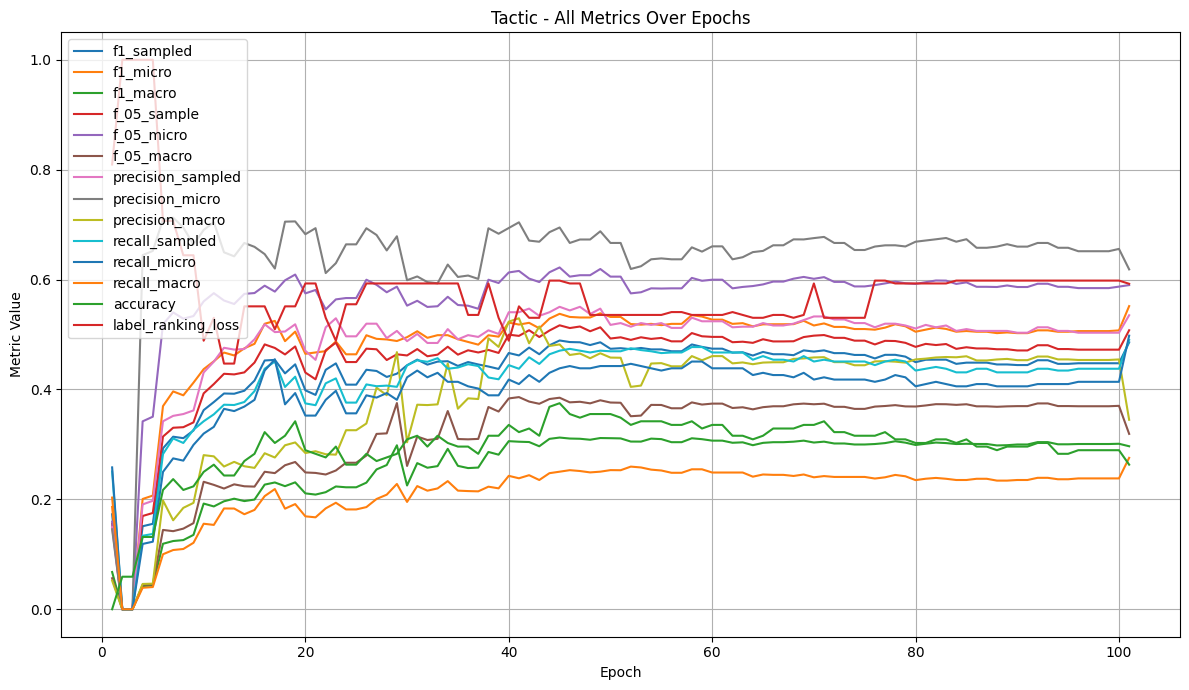

In [257]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    print(f"{metric_name}: {len(values)}")
    if metric_name != 'lrap' and metric_name != 'coverage_error':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic - All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

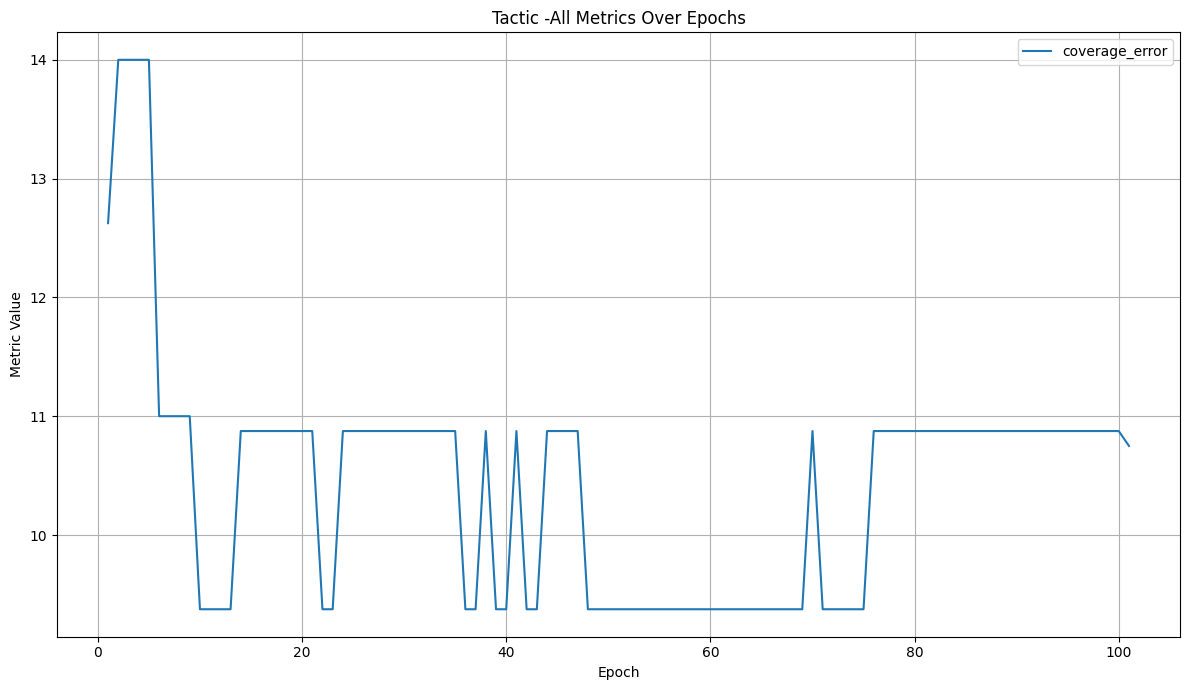

In [258]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    # print(f"{metric_name}: {len(values)}")
    if metric_name == 'coverage_error':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic -All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

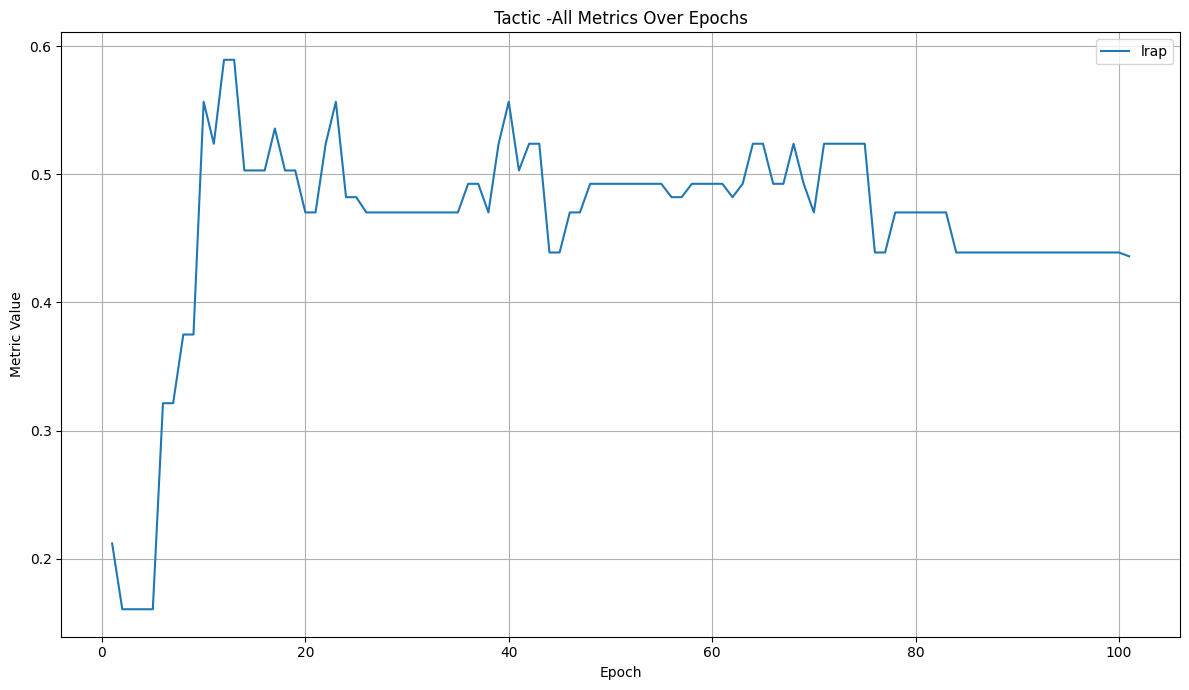

In [259]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    # print(f"{metric_name}: {len(values)}")
    if metric_name == 'lrap':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic -All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [260]:
def print_F1_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = f1_score(y_true, y_pred, average=None)


  Y_count = Y.apply(np.sum, axis=0)

  # print(Y_count[0:14])

  Y_count_sorted = Y_count[0:14].sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("F1 Score")

  ax = plt.gca()
  plt.show()

In [261]:
def print_precision_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = precision_score(y_true, y_pred, average=None)


  Y_count = Y.apply(np.sum, axis=0)

  # print(Y_count[0:14])

  Y_count_sorted = Y_count[0:14].sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("Precision Score")

  ax = plt.gca()
  plt.show()

In [262]:
def compute_metrics(predicted_y, true_y, metric_function, columns, limit):
  results = pd.DataFrame(columns = columns)
  if (metric_function == accuracy_score):
    results.loc[len(results)] = metric_function(true_y, predicted_y)
  else:
    results.loc[len(results)] = metric_function(true_y, predicted_y, average=None)

  sorted_results = results.sort_values(by=0, axis=1, ascending=False)

  for col in sorted_results.columns[:limit]:
        print(f"{col}: {sorted_results[col].values[0]}")

  return sorted_results.iloc[:, :limit]

In [ ]:
df = pd.read_csv('merged_all_columns.csv', encoding='utf-8')
# df_attack['tactic_label'] = df_attack.apply(lambda x: list(x[TACTIC]), axis=1)
# df_attack['technique_label'] = df_attack.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df_tactic_labels = df[TACTIC]
df_technique_labels = df[TECHNIQUE]

df['tactic_label'] = df.apply(lambda x: list(x[TACTIC]), axis=1)
df['technique_label'] = df.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df['text_clean'] = df['Text'].map(lambda t: preprocess(t))


train, test = train_test_split(df, test_size=0.2, random_state=2222)
validation, test = train_test_split(test, test_size=0.5, random_state=2222)


In [268]:
print("------Validation results --------")
print(BEST_F1)

print("F1 scores per class")
y_train_df = train.drop(train.columns[0:2], axis=1)

f1_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, f1_score, test.columns[2:16], 14)
print("----------------------------------")

print("Recall scores per class")
recall_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, recall_score, test.columns[2:16], 14)
print("----------------------------------")

print("Precision scores per class")
precision_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, precision_score, test.columns[2:16], 14)
print("----------------------------------")

print("Accuracy scores per class")
acc_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, accuracy_score, test.columns[2:16], 14)

------Validation results --------
0.5141522252930915
F1 scores per class
TA0040: 0.7457627118644068
TA0002: 0.6990291262135923
TA0001: 0.56
TA0008: 0.5
TA0009: 0.46808510638297873
TA0004: 0.45
TA0006: 0.4444444444444444
TA0043: 0.4
TA0005: 0.09523809523809523
TA0003: 0.0
TA0010: 0.0
TA0007: 0.0
TA0011: 0.0
TA0042: 0.0
----------------------------------
Recall scores per class
TA0040: 0.6875
TA0002: 0.6792452830188679
TA0001: 0.45652173913043476
TA0009: 0.39285714285714285
TA0006: 0.3333333333333333
TA0008: 0.3333333333333333
TA0004: 0.3103448275862069
TA0043: 0.25
TA0005: 0.0625
TA0003: 0.0
TA0010: 0.0
TA0007: 0.0
TA0011: 0.0
TA0042: 0.0
----------------------------------
Precision scores per class
TA0043: 1.0
TA0008: 1.0
TA0004: 0.8181818181818182
TA0040: 0.8148148148148148
TA0001: 0.7241379310344828
TA0002: 0.72
TA0006: 0.6666666666666666
TA0009: 0.5789473684210527
TA0005: 0.2
TA0003: 0.0
TA0010: 0.0
TA0007: 0.0
TA0011: 0.0
TA0042: 0.0
----------------------------------
Accuracy scor

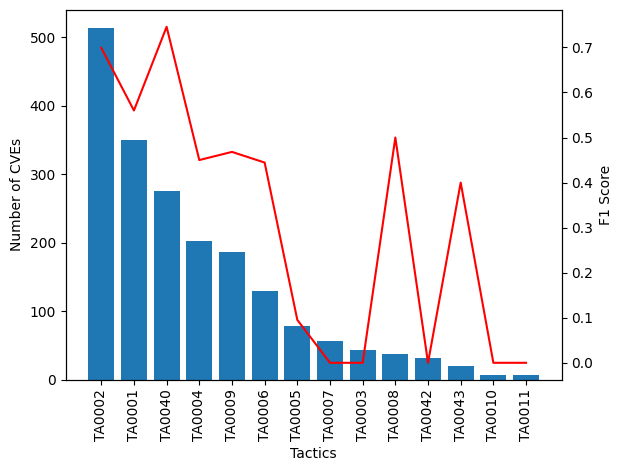

In [269]:
print_F1_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  test.columns[2:16])

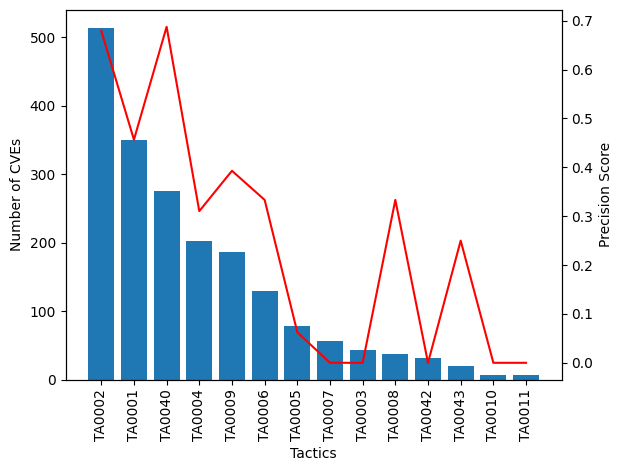

In [270]:
print_precision_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  test.columns[2:16])